# <h1 style="font-family:verdana;"> <center>🏆 Blicommerce Data Analysis Series 🐋</center> </h1>
<p><center style="color:#159364; font-family:cursive;"><cite>Always find opportunities & money even if the data is not real. The Series~</cite></center></p>

<div style="text-align:center"><img src="../figure/ecommerce-attachment.jpg" width="600" height="600"/></div>

# <font color="darkblue" size=+2.5><b>Table of Content</b></font>

<ol start="0">
  <li>Changelog</li>
  <li>Libraries</li>
    <ul>
      <li>Sanity Check</li>
    </ul>
  <li>Understanding Data</li>
  <li>Business Question</li>
  <ul>
      <li>Orders on E-Commerce</li>
      <li>Payment Type Analysis</li>
      <li>Recency Analysis</li>
      <li>Location Analysis</li>
      <li>Shipping Analysis</li>
    </ul>
  <li>Reference</li>
</ol>


The objective of this notebook is to *propose an analytical view* from various aspect of an **e-commerce business process** in Indonesia. In order to do that, we will do **EDA** (exploratory data analysis) using various **graphical tools** to answer the **business question** from different aspect of business process in the ecommerce.

While it will be an extensive journey to understand the data and plotting useful charts to clarify our assumption and get many insight from the data, we will be able to understand more on how to do data analytics in this notebook. I hope that this notebook might be useful for future reference!



<a id="1"></a>
# <font color="slategray" size=+1.5><b>Changelog</b></font>








---
***Update v0.1:*** 31/05/2021

- Initialize the data analytics notebook 
- Putting all the analytics process from previous work into this notebook

---
***Update v0.2:*** 04/06/2021

- Improve performance by saving geolocation data in database

---
***Update v0.3:*** 05/06/2021

- Updating Recency Analysis & Order Trend Background & Assumption based on new reference
- Updating Recency Analysis & Order Trend Dashboard (part I)
- Refactor dashboard code quality
- Adding new schema representation for OLTP & OLAP

---
***Update v0.4:*** 06/06/2021

- Updating Logistic Analysis Background & Assumption based on new reference
- Updating Logistic Dashboard (part I)
- Creating logistic route path for ecommerce delivery 

---
***Update v0.5:*** 25/06/2021

- Simplify order trend in date seasonality
- Add percentage to compare for each payment type along the order
- Add spending per recency segment to compare

---
***Update v0.6:*** 27/06/2021

- Revision on line plot
- Change color theme and overall visualization theme
- Change font usage theme
- Update on analysis explanation
---
***Update v0.7:*** 10/07/2021

- Revision after Ci Gaby review result
- Add top categories of product from each customer segment 
- Add top categories product from each most ordered destination (For base of recommender system).
---
***Update v0.8:*** 22/07/2021

- Finalization
---

# <font color="darkblue" size=+2.5><b><center>1. Libraries</center></b></font>

In [12]:
# Sys utils lib
import json
import sys

# Mathematics related lib
import numpy as np
import scipy as sp
import pandas as pd

# SQL Engine
import psycopg2
from sqlalchemy import create_engine

# Profiling process
from tqdm import tqdm

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Visualization
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import joypy
from matplotlib.ticker import FuncFormatter

# Map Visualization
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl, DualMap

# Legend Tools
import matplotlib as mpl
from matplotlib.patches import Patch
from cycler import cycler

# Mapping Object
import plotly.graph_objects as go

# Custom visualization
from utils.viz_utils import single_countplot, countplot, data_overview, make_autopct, format_spines, boxenplot, aggr_donut_plot

In [13]:
# Setting up visualization config
%matplotlib inline
pd.set_option('display.max_columns', 100)

plt.style.use('default')

# === Color pallete ===
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0),  # Yellow
    (255, 255, 255), # White
    (0, 0, 0), # Black
]

# Color constant
color1 = "#F36E8E"
color2 = "#1ABDE9"

light_palette = np.array(raw_light_palette)/255

mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.prop_cycle'] = cycler('color',light_palette)

## <font color="black" size=+1.5><b>Sanity Check</b></font>

In [14]:
import json

def load_config(file_path: str = "./config.json"):
    with open(file_path) as config_file:
        data = json.load(config_file)
    return data

config = load_config("../config.json")
DBNAME = config.get("DBNAME")
HOSTNAME = config.get("HOSTNAME")
USER = config.get("USER")
PASS = config.get("PASS")
SCHEMA = config.get("SCHEMA")

In [15]:
# Load data

# Create an engine instance
alchemyEngine = create_engine(
    f'postgresql+psycopg2://{USER}:{PASS}@{HOSTNAME}/{DBNAME}', pool_recycle=3600)

# Connect to PostgreSQL server
conn = alchemyEngine.connect()

schema = SCHEMA

## <font color="black" size=+1.5><b>Geo Location Mapping</b></font>

In [16]:
GEO_QUERY = """
select *
from staging.dim_geo
"""
df_geo = pd.read_sql_query(GEO_QUERY, conn)

In [17]:
# Customizing current map with default pandas map
def mapping_geolocation(val):
    mapping = {
        "DKI JAKARTA" : "JAKARTA RAYA",
        "KALIMANTAN UTARA" : "KALIMANTAN TENGAH",
        "DI YOGYAKARTA" : "YOGYAKARTA",
        "KEPULAUAN BANGKA BELITUNG" : "BANGKA BELITUNG"
    }
    if (val in mapping) :
        return mapping[val]
    return val

## <font color="black" size=+1.5><b>Chart Studio Activation</b></font>

In [18]:
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
username='William9923'
api_key='zlYlgf4erfyxVdQLN5Kc'
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

---
# <font color="darkblue" size=+2.5><b><center>2. Understanding Data</center></b></font>

***
<font size=-1.0><i>This is the structure of the data warehouse that we are going to explore</i></font>
***


![OLTP-diagram](https://i.ibb.co/rkGQtLN/OLTP-diagram.png) 


![OLAP-diagram](https://i.ibb.co/Z1ZWhFT/OLAP-diagram.png)

***
<font size=-1.0><i>Before we go any furthur, lets look at each dataset information in warehouse</i></font>
***

In [19]:
date = pd.read_sql_table("dim_date", conn, schema=schema)
time = pd.read_sql_table("dim_time", conn, schema=schema)
geo = pd.read_sql_table("dim_geo", conn, schema=schema)
user = pd.read_sql_table("dim_user", conn, schema=schema)
product = pd.read_sql_table("dim_product", conn, schema=schema)
seller = pd.read_sql_table("dim_seller", conn, schema=schema)
feedback = pd.read_sql_table("dim_feedback", conn, schema=schema)
fct_order_item = pd.read_sql_table("fct_order_items", conn, schema=schema)

# Collections for each dataset
datasets = [date, time, geo, user, product, seller, feedback, fct_order_item]
names = ['Date', 'Time', "Geo", 'User', 'Product', 'Seller', 'Feedback', 'Order']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['Dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

---
# <font color="darkblue" size=+2.5><b><center>3. Business Question</center></b></font>

## <font color="black" size=+1.5><b>3.1 Orders on E-Commerce</b></font>

<font color="slategray" size=+0.5><b>Purpose</b></font>

<font size=-1><i>
  <ul>
    <li>When is the <b>peak season</b> of our ecommerce ? </li>
    <li>What is the <b>growth rate</b> for the ecommerce based on purchase rate?</li>
    <li>What time users are most likely <b>make an order<b> or using the ecommerce app?</li>
  </ul>
</i></font>

<font color="slategray" size=+0.5><b>Background</b></font>

<font size=-1><i>
One of the best information that we can get to improve our ecommerce are by digging our own ecommerce past data. Using analytics, we can define which offer given to customer that were effective and not effective. On this analysis, we would want to know when the peak season of our ecommerce in order to understand what offer is the best for user (promotions, ads channel, timing, etc). Knowing when is the ecommerce user most likely to purchase (peak season) might be able to help ecommerce peak season preparation. 
<br>
Not only that we also want to find sales trend as it is one of the most important aspect in ecommerce. As one of the main business process e-commerce can offer, knowing the growth of the ecommerce might help furthur business direction. The insight that we get from understanding the trend in the ecommerce can be used to predict furthur sales and what to prepare for furthur development for the ecommerce.
<br>
Understanding when the user is most likely to purchase or using the application might help too, since it helps us to understand certain purchase pattern and can make better marketing related decision.
</i></font>

<font color="slategray" size=+0.5><b>In General & Assumption</b></font>

<font size=-1><i>
<b>Peak Season</b>, is actually very common for any retail/e-commerce businesses. Peak Season period usually lasts from Halloween until a few weeks after New Years, with many days within those timeframe having very extreme sales.
For this analysis, I will assume that the ecommerce is in <b>Indonesia</b> (based on the location of its user & seller).
<br>
As more people in Indonesia start to use more of technology, with the average daily usage reaching 4 hours a day (twice than people in USA), I would like to say that most likely the ecommerce that we are going to analyze will have growing trend. 
<br>
In general, we could see the growth trend of Indonesia ecommerce on below picture :
![Indonesia Growth Trend](../figure/order-trend-data.png)
<br>
Peak season in Indonesia normally happen when ecommerce held special event such as flash sale or special discount on certain days, such as : 
<ul>
  <font size=-1>
    <li>Haloween - 31 Oct</li>
    <li>Harbolnas (12.12) - 12 Dec</li>
    <li>Valentine - 14 Feb</li>
    <li>Christmas Eve - 24 Dec</li>
    <li>Black Friday</li>
  </font>
</ul>
and many more ...
</i></font>

In [20]:
# Init needed data

QUERY = """
select 
	foi.order_id ,
	MIN(u.user_name) as user_name,
	MIN(foi.total_payment_value) as order_value,
	MIN(dd."date") as order_date,
	MIN(dd.day_of_year) as order_day_of_year,
	MIN(dd.day_of_month) as order_day_of_month,
	MIN(dd.day_of_quarter) as order_day_of_quarter,
	MIN(dd.day_name) as order_day_name,
	MIN(dd.day_of_week) as order_day_of_week,
	MIN(dd.month_actual) as order_month,
	MIN(dd.month_name) as order_month_name,
	MIN(dd.week_of_month) as order_week_of_month,
	MIN(dd."year") as order_year,
	case when MIN(dd."isWeekend"::int) = 1 then true else false end as order_is_weekend ,
	MIN(dt."hour") as order_time
from staging.fct_order_items foi
left outer join staging.dim_date dd on foi.order_date = dd.date_id 
left outer join staging.dim_time dt on foi.order_time = dt.time_id 
left outer join (
	select 
		du.user_key ,
		du.user_name
	from staging.dim_user du 
	where du.is_current_version=true
) u on foi.user_key = u.user_key
group by foi.order_id;
"""

# Init dataframe
df = pd.read_sql_query(QUERY, conn)
df['order_year_month'] = df['order_date'].apply(lambda x: x.strftime('%Y%m'))
trend_year = df.groupby(['order_year']).agg(value=('order_value', 'sum'), num_of_transaction=('order_id', 'count')).reset_index()
trend_date=df.groupby('order_date').agg({'order_id':'count', 'order_value': 'sum'}).rename(columns={'order_id':'freq_order', 'order_value' : 'total_value'}).reset_index()
trend_hour=df.groupby('order_time').agg({'order_id':'count', 'order_value': 'sum'}).rename(columns={'order_id':'freq_order', 'order_value' : 'total_value'}).reset_index()

In [21]:
# Overtime Order Frequency

fig = px.line(trend_date, x='order_date', y='freq_order', title="Order Frequency over the date", template='plotly_white')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    ),
    title_text='Date'
)

fig.update_yaxes(title_text='Total Purchase Count')
fig.show()
# py.plot(fig, filename="order_trend_lineplot", auto_open = True)

---

<font size=-1><i>
Data given only provide us information about order in ecommerce from Sept 2016 - Sept 2018 (2 years). That might be one of the reason order frequency in 2016 is so low. 
<br>
Based on the line plot, there are some notes that might worth the attention : 
<ul>
  <font size=-1>
    <li>There are order / sales spike in 24 Nov 2017. Based on information in internet, that day is the famous <b>Black Friday</b>.</li>
    <li>At the end of the 2016, the sales is weak. Is it possible that most seller in the ecommerce have end year holiday ? </li>
  </font>
</ul>
    <font size=-1>
Because of the lack of data for early 2016 and end of 2018, we are unable to conclude more of significant findings here. But we know for sure that 24 Nov 2017 - end of Nov 2017 is the peak season for our ecommerce. Find what offer that the ecommerce gave to user to increase the sales!</font>
</i></font>

---


<font size=-1><i>
<pre>
What is the growing trend on the e-commerce that were located in Indonesia? 
</pre>
To answer that question, I will try to give deep dive on the trend for order frequency in the ecommerce from end of 2016 - mid 2018.
</i>
</font>

***

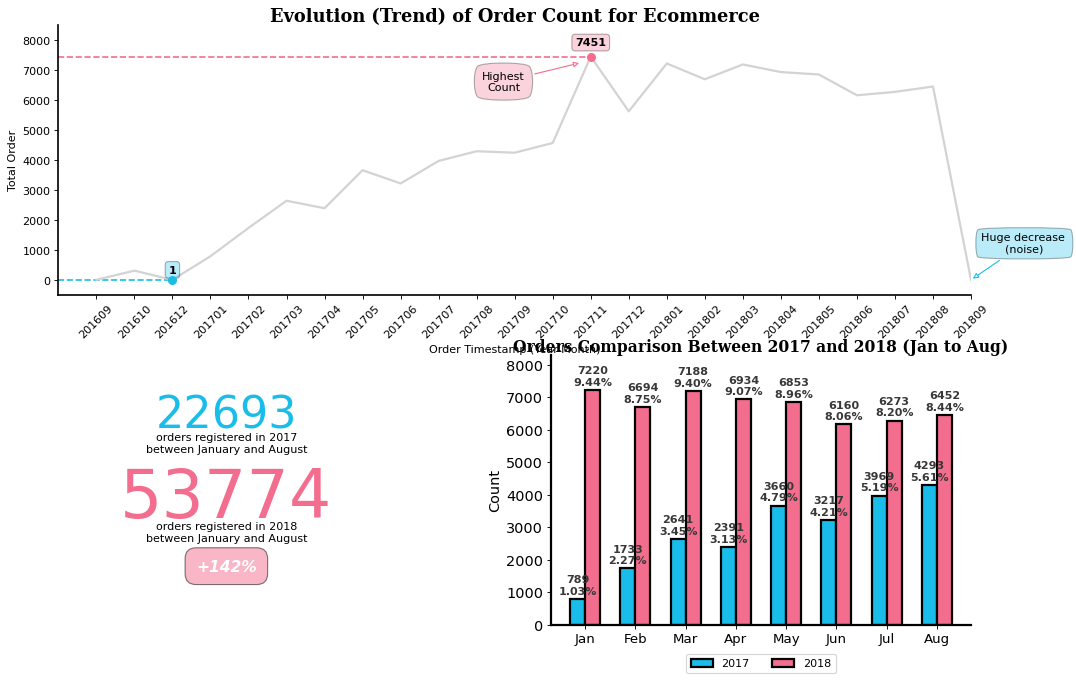

In [22]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

data = df['order_year_month'].value_counts().sort_index()
x = data.index 
y = data.values 
# ax1.plot(x, y, color='lightgray',linewidth=2,)

sns.lineplot(data=df['order_year_month'].value_counts().sort_index(), ax=ax1, 
             color='lightgray', linewidth=2)

ax1.scatter(x[np.argmax(y)], np.max(y), c=color1,s=50, zorder=20)
ax1.scatter(x[np.argmin(y)], np.min(y), c=color2,s=50, zorder=20)

ax1.annotate(f'Highest\nCount', (12.75, 7250), xytext=(-70, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc=color1, ec='black', alpha=0.3, pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w', color=color1), ha='center')
ax1.annotate(f'Huge decrease \n(noise)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc=color2, ec='black', alpha=0.3, pad=.5, ),
             arrowprops=dict(arrowstyle='-|>', fc='w', color=color2), ha='center') 

ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['left'].set_linewidth(1.5)

ax1.set_ylim(-500, 8500)

# Spine
for s in ['top', 'right']:
    ax1.spines[s].set_visible(False)
ax1.margins(0)

ax1.text(x[np.argmax(y)], np.max(y)+300, s=f'{np.max(y)}', fontweight='bold',
         va='bottom', ha='center', 
         bbox=dict(boxstyle='round,pad=0.3', fc=color1, ec='black', alpha=0.3))

ax1.text(x[np.argmin(y)], np.min(y)+500, s=f'{np.min(y)}', fontweight='bold',
         va='top', ha='center', 
         bbox=dict(boxstyle='round,pad=0.3', fc=color2, ec='black', alpha=0.3))

ax1.set_xlabel("Order Timestamp (Year-Month)")
ax1.set_ylabel("Total Order")

ax1.hlines(np.max(y), xmin=-1, xmax=x[np.argmax(y)], linestyle='--', color=color1)
ax1.hlines(np.min(y), xmin=-1, xmax=x[np.argmin(y)], linestyle='--', color=color2)

ax1.set_title(f"Evolution (Trend) of Order Count for Ecommerce", loc='center', fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_compare = df.query('order_year in (2017, 2018) & order_month <= 8')
year_orders = df_compare['order_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax2.text(0.40, 0.73, f'{year_orders[2017]}', fontsize=40, color=color2, ha='center')
ax2.text(0.40, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.40, 0.40, f'{year_orders[2018]}', fontsize=60, color=color1, ha='center')
ax2.text(0.40, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.40, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor=color1, alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
x = np.arange(len(month_label)) 
y1 = df_compare.loc[df_compare.order_year == 2017].order_month.value_counts().sort_index().values
y2 = df_compare.loc[df_compare.order_year == 2018].order_month.value_counts().sort_index().values
width=0.3

# First Bar Plot
ax3.bar(x-width/2, y1, 
       color='#1ABDE9',
       edgecolor='black',
       linewidth=2,
       width=width,
       label='2017'
      )

# Second Bar Plot
ax3.bar(x+width/2, y2, 
       color='#F36E8E',
       edgecolor='black',
       linewidth=2,
       width=width,
       label='2018'
      )

# Annotate
for idx, item in enumerate(x):
  # Percentage
  ax3.annotate(f"{(y1[idx] / sum(y1+y2)) * 100:.2f}%", 
                  xy=(item-width/2, y1[idx] + 250),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )
  ax3.annotate(f"{y1[idx]}", 
                  xy=(item-width/2, y1[idx] + 600),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )
  ax3.annotate(f"{(y2[idx] / sum(y1+y2) * 100):.2f}%", 
                  xy=(item+width/2, y2[idx] + 250),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )
  ax3.annotate(f"{y2[idx]}", 
                  xy=(item+width/2, y2[idx] + 600),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )

# Spine
ax3.spines['bottom'].set_linewidth(2)
ax3.spines['left'].set_linewidth(2)

# Legend & Ticks
ax3.set_title('Orders Comparison Between 2017 and 2018 (Jan to Aug)', loc='center', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax3.set_ylabel("Count", fontsize=13, fontweight='medium')
ax3.set_ylim(0,8300)
ax3.set_xticks(x)
ax3.set_xticklabels(month_label, fontsize=12)
ax3.tick_params(axis='y', which='major', labelsize=13)
ax3.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.2))

plt.savefig("../reports/visualization/order-trend1.png")
plt.tight_layout()
plt.show()

---

<font size=-1><i>
Based the chart above we can conclude that ecommerce that we analyze has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more likely to buy from our ecommerce than before.
<br>
Not only that, we can see that Nov 2017 is the highest peak season for our ecommerce. Most likely it happens because of the previous finding of <b>Black Friday</b> event that the ecommerce held. As a side note, we can see sharp decrease of order frequency from August 2018 - Sept 2018. It looks like there is some cutoff from the data (noise).
<br>
In order to see more clearly for the ecommerce growth, I use the data between Jan 2017 - Aug 2017 and compare it to Jan 2017 - Aug 2018. Based on the data, we could see that the ecommerce really improve within 1 year span.
<br>
From the order percentage comparison itself, it we could see that as time goes on, the difference started to stabilize around 35% - 40% vs 60% - 65% for 2017 vs 2018.
</i></font>

---

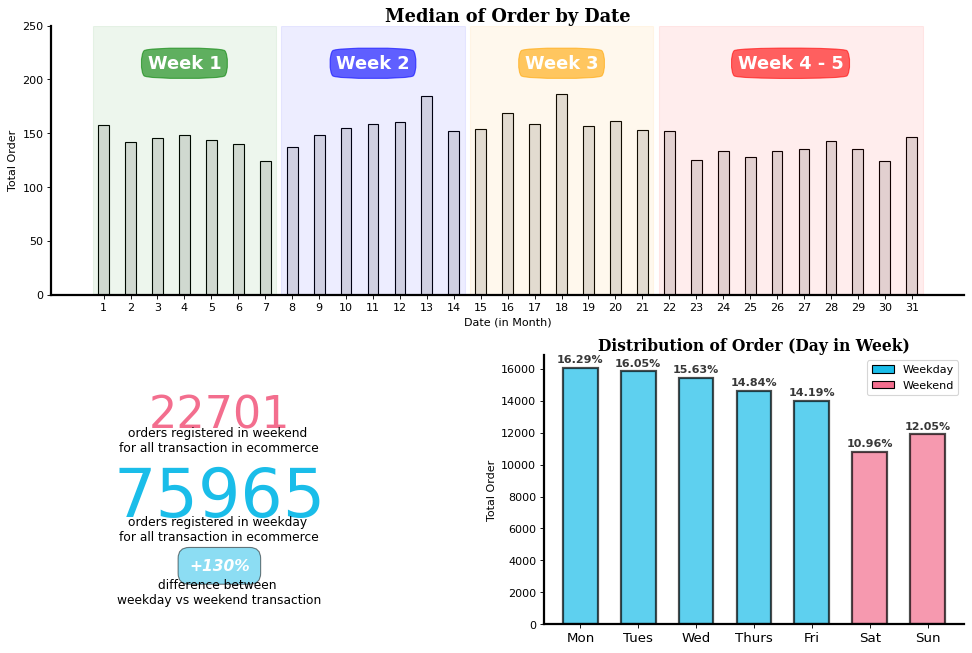

In [23]:
bar_color = "#e0e0e0"
weekend_color = "#3caea3"

# Color constant
color1 = "#F36E8E"
color2 = "#1ABDE9"

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# === Barplot day in month ===
x = df.order_day_of_month.value_counts().sort_index().index
day_month = df.groupby(by=['order_year', 'order_month','order_day_of_month']).agg(value=('order_id', 'size')).reset_index()[['order_day_of_month', 'value']]
y = day_month.groupby(['order_day_of_month']).agg(value=('value', 'median')).value.values
ax1.bar(x, y,  color=bar_color, width=0.4, edgecolor='black')
ax1.set_title(f'Median of Order by Date', fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_xticks(list(x))
ax1.set_xlabel("Date (in Month)")
ax1.set_ylabel("Total Order")
ax1.set_ylim(0, 250)

color =  ['green',  'blue',  'orange',  'red']
span_range = [[1, 7], [8,  14], [15, 21], [22, 31]]
height = 215
for idx, sub_title in enumerate(['Week 1', 'Week 2', 'Week 3', 'Week 4 - 5']):
  ax1.annotate(sub_title,
              xy=(sum(span_range[idx])/2 ,height),
              xytext=(0,0), textcoords='offset points',
              va="center", ha="center",
              color="w", fontsize=16, fontweight='bold',
              bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
  ax1.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.07)

# Spine
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)

# Spine
for s in ['top', 'right']:
    ax1.spines[s].set_visible(False)

# === Annotation for weekend ===
week_orders = df['order_is_weekend'].value_counts()
growth = int(round(100 * (1 + week_orders[True] / week_orders[False]), 0))
ax2.text(0.40, 0.73, f'{ week_orders[True]}', fontsize=40, color=color1, ha='center')
ax2.text(0.40, 0.64, 'orders registered in weekend \nfor all transaction in ecommerce', fontsize=11, ha='center')
ax2.text(0.40, 0.40, f'{week_orders[False]}', fontsize=60, color=color2, ha='center')
ax2.text(0.40, 0.31, 'orders registered in weekday \nfor all transaction in ecommerce', fontsize=11, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.40, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor=color2, alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.text(0.40, 0.075, 'difference between \nweekday vs weekend transaction', fontsize=11, ha='center')
ax2.axis('off')

# === Countplot ===
week_label = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
x = df.order_day_of_week.value_counts().sort_index().index
y = df.order_day_of_week.value_counts().sort_index().values
color_map = [color2 for _ in range(len(x))]
color_map[-2:] = [color1 for _ in range(2)] # For weekend
ax3.bar(x, y,  color=color_map, width=0.6, edgecolor='black', alpha=0.7,linewidth=2)
ax3.set_title(f'Distribution of Order (Day in Week)', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax3.set_xticks(list(x))
ax3.set_xticklabels(week_label, fontsize=12)
ax3.set_ylabel("Total Order")
# Spine
ax3.spines['bottom'].set_linewidth(2)
ax3.spines['left'].set_linewidth(2)

legend_elements = [
  Patch(facecolor=color2, edgecolor='black', label='Weekday'), 
  Patch(facecolor=color1, edgecolor='black', label='Weekend')
]
ax3.legend(handles=legend_elements,loc='upper right', ncol=1)

# Annotate
for idx, item in enumerate(x):
    ax3.annotate(f"{(y[idx] / sum(y)) * 100:.2f}%", 
                   xy=(item, y[idx] + 500),
                   va = 'center', ha='center',fontweight='bold', color='#383838'
                  )

# Spine
for s in ['top',  'right']:
    ax3.spines[s].set_visible(False)

plt.savefig("../reports/visualization/order-trend2.png")
plt.tight_layout()
plt.show()

---

<font size=-1><i>
Using above plot, we can identify seasonality peak that happen frequently to see when user most likely to make purchase. Based on plot above, we could takes some notes : 
<ul>
<font size=-1>
  <li>From day in month seasonality, we can also see that it distributed equally. But we can see that most user prefer not to order at the end of the month because the bar plot slightly lower in end of the month</li>
  <li>Based from the day in a week distribution, we can see that our customer tend to make order in the weekdays than in the weekend.</li>
</font>
</ul>
</i></font>



---

<font size=-1><i>

<ul>
<font size=-1>
<li>What about time seasonality ? Is there any specific hour over the day that indicate more user use the ecommerce?</li>
</font>
</ul>

</i></font>

---

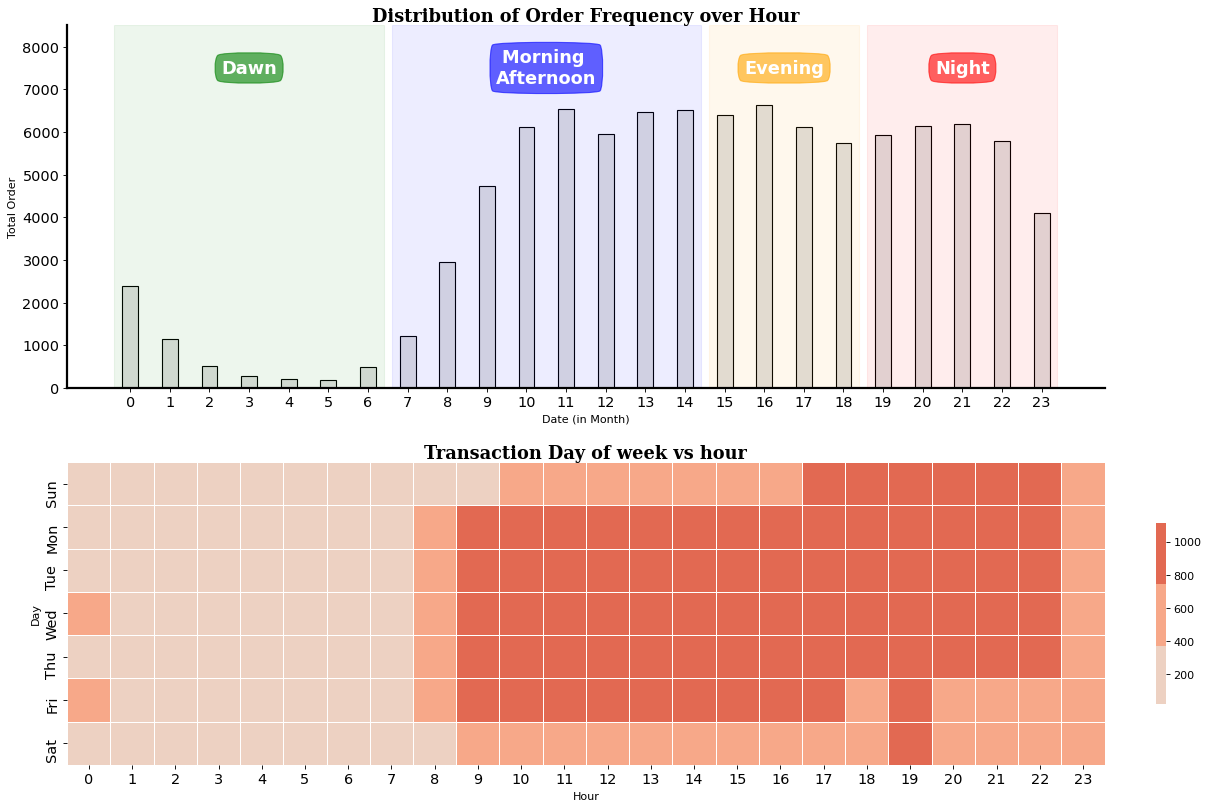

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

# === Barplot day in month ===
x = df.order_time.value_counts().sort_index().index
y = df.order_time.value_counts().sort_index().values
ax1.bar(x, y,  color=bar_color, width=0.4, edgecolor='black')
ax1.set_title(f'Distribution of Order Frequency over Hour', fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_xticks(list(x))
ax1.set_xlabel("Date (in Month)")
ax1.set_ylabel("Total Order")
ax1.set_ylim(0, 8500)

color =  ['green',  'blue',  'orange',  'red']
span_range = [[0, 6], [7,  14], [15, 18], [19, 23]]
height = 7500
for idx, sub_title in enumerate(['Dawn', 'Morning \nAfternoon', 'Evening', 'Night']):
  ax1.annotate(sub_title,
              xy=(sum(span_range[idx])/2 ,height),
              xytext=(0,0), textcoords='offset points',
              va="center", ha="center",
              color="w", fontsize=16, fontweight='bold',
              bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
  ax1.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.07)

# Spine
for s in ['top', 'right']:
    ax1.spines[s].set_visible(False)
  
# Spine
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)

# === Transaction Day of week vs hour ===
df['weekday'] = df.apply(
    lambda x: x['order_day_name'].replace('day', '')[:3],
    axis=1
)
df['weekday']=pd.Categorical(df['weekday'],categories=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],ordered=True)
day_hour=df.groupby(['weekday','order_time']).agg({'order_id':'count'}).rename(columns={'order_id':'freq'}).reset_index()
day_hour = day_hour.pivot('weekday','order_time','freq')

# == Plotting ==
sns.heatmap(day_hour,  cmap=sns.color_palette("coolwarm"), center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)
ax2.set_xlabel("Hour")
ax2.set_ylabel("Day")
ax2.set_title("Transaction Day of week vs hour",fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')

for ax in [ax1,ax2]:
  # Ticklabels
  ax.tick_params(axis='y', which='major', labelsize=13)
  ax.tick_params(axis='x', which='major', labelsize=13)

plt.savefig("../reports/visualization/order-trend3.png")
plt.show()

---

<font size=-1><i>
From the <b>distribution of order over hour</b>, we can see that order frequency steadily rises as the day progress and reaches the peak after noon and continues until about 22.00, then lower with dawn having the lowest order frequency than other daytime period.  
<br>
Also the order time heatmap, we can see a quite interesting facts about user order time preference weekdays & weekend. On weekdays, user most likely to order from morning - night, while on weekends user tends to order from nightime. 

</i></font>

---

<font color="slategray" size=+0.5><b>Insight</b></font>

<font size=-1>
<i>
As final takeaway, here are the things that we need to pay attention : 
<ul>
  <font size=-1>
  <li>Data provide us with order information from Sept 2016 - Sept 2018. Few reason on why 2016 data is so low are either ecommerce only started or many data loss due to not having a good system.</li>
  <li>There are order / sales spike in 24 Nov 2017. Based on information in internet, that day is the famous <b>Black Friday</b>.</li>
  <li>At the end of the 2016, the sales is weak. It seems possible that most seller in the ecommerce have end year holiday in 2016, but when we see the end of 2017, the same pattern not occuring, might indicate that the data in the end of 2016 have noise </li>
  <li>Our ecommerce has a growing trend. While there are some We can peaks at specific months, but in general we can see clear that customers are more likely to buy from our ecommerce than before.</li>
  <li>Based on comparison between Jan 2017 - Aug 2017 and Jan 2017 - Aug 2018, we can see that our ecommerce have 142% growth of order frequency </li>
  <li>By seeing user tendencies in purchasing, we know that user most likely to buy in weekdays than in the weekend, and not likely to purchase at the end of the month</li>
  <li>From hour over the day tendencies, we can see that order frequency steadily rises as the day progress and reaches the peak after noon and continues until about 22.00, and while during weekdays , the order frequency increases steadly after 9 AM, meanwhile the order frequency picks up only after noon during weekends.</li>
 
  </font>
</ul>
</i></font>

<font color="slategray" size=+0.5><b>Recommendation</b></font>

<font size=-1><i>
Based on insight that we get from the order analysis, we can recommend few things:
<ul>
  <font size=-1>
  <li>A/B Testing peak season offer to find out which offer actually customer into to help us learn more about what resonates with your audience and drive online sales. (Can be about offer, customer service, discount, cashback, and many more through that certain timestamp of peak season).</li>
  <li>Make much more offer similar to Black Friday Event, such as HarBolNas (Hari Belanja Nasional) to improve sales and lower new customer cost. We can see that by such event we can get more sales up to 3x from normal days</li>
  <li>Based on when user is using the ecommerce application, it is safe to say that most people like to use in weekdays (Mon - Fri) afternoon - evening (11.00 - 16.00). Use that time to make special offer in a specific duration only such as flash sale to increase sales & popularity.</li>

  <font>
</ul>
</i></font>

## <font color="black" size=+1.5><b>3.2 Payment Type Analysis</b></font>

<font color="slategray" size=+0.5><b>Purpose</b></font>

<font size=-1><i>
  <ul>
    <li>What is the <b>preferred</b> way to pay in the ecommerce?</li>
    <li>How many installment is usually done when paying in the ecommerce?</li>
  </ul>
</i></font>

<font color="slategray" size=+0.5><b>Background</b></font>

<font size=-1>
<i>
In ecommerce, payment analytics may help us to make better business decision. By understanding the local conversion rate & preferred payment type, we might be able to ease & attract more new user to use our ecommerce service.
<br>
Not only that, we could also reduce the number of abandonment rate when user check out the basket by providing the payment type that were used by many people (popular) & benefit the user itself. Studies of ecommerce in the world show that the average abondonment rate from its user is about 68.81%, with the most recent study shows about 74,52%.
<br>
Depending on the country & customer preference, the prefered payment method might differ. That's why payment analysis is important to identify / clarify the most popular payment type used by user and ways to improve it.
</i></font>

<font color="slategray" size=+0.5><b>In General & Assumption</b></font>

<font size=-1><i>
Before we do the work, I would like to inform that e-payment used in ecommerce most of the times can be categorized into 3 categories:
<ul>
  <font size=-1>
  <li>credit based</li>
  <li>Alternative e-payment that use bank as its medium (debit, etc)</li>
  <li>digital wallet (3rd party)</li>
  <font>
</ul>
Based on my assumption and research, I think that most of the time Indonesian would like to use credit card / debit as the most "preferred" way to pay. As for the digital wallet, it might have a good trend, but still regulation might hinder the usage in Indonesia.
</i></font>

In [25]:
QUERY = """
-- Payment Datamart
-- Datamart 5
select 
	foi.order_id ,
	MAX(foi.num_blipay) as num_blipay,
	MAX(foi.num_credit_card) as num_credit_card,
	MAX(foi.num_debit) as num_debit,
	MAX(foi.num_voucher) as num_voucher,
	MAX(foi.num_unknown) as num_unknown,
	MAX(foi.total_payment_blipay) as total_payment_blipay,
	MAX(foi.total_payment_credit_card) as total_payment_credit_card,
	MAX(foi.total_payment_debit) as total_payment_debit,
	MAX(foi.total_payment_voucher) as total_payment_voucher,
	MAX(foi.total_payment_unknown) as  total_payment_unknown,
    CASE
        WHEN MAX(foi.num_blipay) > 0 THEN MAX(foi.total_payment_blipay) / MAX(foi.num_blipay)
        ELSE 0 
    END as payment_per_installment_blipay,
    CASE
        WHEN MAX(foi.num_credit_card) > 0 THEN MAX(foi.total_payment_credit_card) / MAX(foi.num_credit_card)
        ELSE 0 
    END as payment_per_installment_credit,
    CASE
        WHEN MAX(foi.num_debit) > 0 THEN MAX(foi.total_payment_debit) / MAX(foi.num_debit)
        ELSE 0 
    END as payment_per_installment_debit,
    CASE
        WHEN MAX(foi.num_voucher) > 0 THEN MAX(foi.total_payment_voucher) / MAX(foi.num_voucher)
        ELSE 0 
    END as payment_per_installment_voucher,
    CASE
        WHEN MAX(foi.num_unknown) > 0 THEN MAX(foi.total_payment_unknown) / MAX(foi.num_unknown)
        ELSE 0 
    END as payment_per_installment_unknown
    
from staging.fct_order_items foi 
group by 1
order by 3 desc ,2 desc ,4 desc ,5 desc , 6 desc;
"""

INSTALLMENT_QUERY = """
select 
  distinct
	foi.order_id ,
	foi.num_credit_card ,
  	foi.num_blipay ,
  	foi.num_voucher ,
  	foi.num_debit ,
  	foi.total_payment_installment
from staging.fct_order_items foi 
"""

EVO_QUERY = """
select 
	foi.order_id ,
  
  -- order details
	MIN(dd."date") as order_date,
	
  -- payment details
  MAX(foi.num_blipay) as num_blipay,
	MAX(foi.num_credit_card) as num_credit_card,
	MAX(foi.num_debit) as num_debit,
	MAX(foi.num_voucher) as num_voucher,
	MAX(foi.num_unknown) as num_unknown

from staging.fct_order_items foi
left outer join staging.dim_date dd on foi.order_date = dd.date_id 
group by foi.order_id;
"""


# Init dataframe
df = pd.read_sql_query(QUERY, conn)
installment_df = pd.read_sql_query(INSTALLMENT_QUERY, conn)
evo_df = pd.read_sql_query(EVO_QUERY, conn)
evo_df['order_date'] = pd.to_datetime(evo_df['order_date'], format='%Y-%m-%d')
evo_df['order_year_month'] = evo_df['order_date'].apply(lambda x: x.strftime('%Y%m'))

# Cleaning & Transforming Data

# Number of order
blipay_num = df.loc[df.num_blipay > 0].num_blipay.agg(['sum', 'count', 'mean', 'max'])
credit_num = df.loc[df.num_credit_card > 0].num_credit_card.agg(['sum', 'count', 'mean', 'max'])
debit_num = df.loc[df.num_debit > 0].num_debit.agg(['sum', 'count', 'mean', 'max'])
voucher_num = df.loc[df.num_voucher > 0].num_voucher.agg(['sum', 'count', 'mean', 'max'])

# Value of order
blipay_val = df.loc[df.total_payment_blipay > 0].total_payment_blipay.agg(['sum', 'mean'])
credit_val = df.loc[df.total_payment_credit_card > 0].total_payment_credit_card.agg(['sum', 'mean'])
debit_val = df.loc[df.total_payment_debit > 0].total_payment_debit.agg(['sum', 'mean'])
voucher_val = df.loc[df.total_payment_voucher > 0].total_payment_voucher.agg(['sum', 'mean'])

# Installment
blipay_installment = df.loc[df.payment_per_installment_blipay > 0].payment_per_installment_blipay.agg(['sum', 'mean'])
credit_installment = df.loc[df.payment_per_installment_credit > 0].payment_per_installment_credit.agg(['sum', 'mean'])
debit_installment = df.loc[df.payment_per_installment_debit > 0].payment_per_installment_debit.agg(['sum', 'mean'])
voucher_installment = df.loc[df.payment_per_installment_voucher > 0].payment_per_installment_voucher.agg(['sum', 'mean'])

# Combine dataset
payment = pd.DataFrame({
    "credit" : [credit_num.values[0], credit_num.values[1], credit_num.values[2], credit_num.values[3], credit_val.values[0], credit_val.values[1], credit_installment.values[0], credit_installment.values[1]], 
    "blipay" : [blipay_num.values[0], blipay_num.values[1], blipay_num.values[2], blipay_num.values[3], blipay_val.values[0], blipay_val.values[1], blipay_installment.values[0], blipay_installment.values[1]],
    "voucher" : [voucher_num.values[0], voucher_num.values[1], voucher_num.values[2], voucher_num.values[3], voucher_val.values[0], voucher_val.values[1], voucher_installment.values[0], voucher_installment.values[1]],
    "debit" : [debit_num.values[0], debit_num.values[1], debit_num.values[2], debit_num.values[3], debit_val.values[0], debit_val.values[1], debit_installment.values[0], debit_installment.values[1]],  
})
payment = payment.T
payment.columns = ['total_usage', 'order_count', 'installment_avg', 'installment_max', 'total_value', 'avg_value', 'total_installment_value ', 'avg_installment_value']


***
<font size=-1><i>
To answer the question about what is the <b>preferred</b> way to pay and <b>number of installment</b> in the ecommerce, I will create a simple dashboard to  show enough information to clarify how e-commerce buyers usually prefer to pay orders.
</i></font>
***

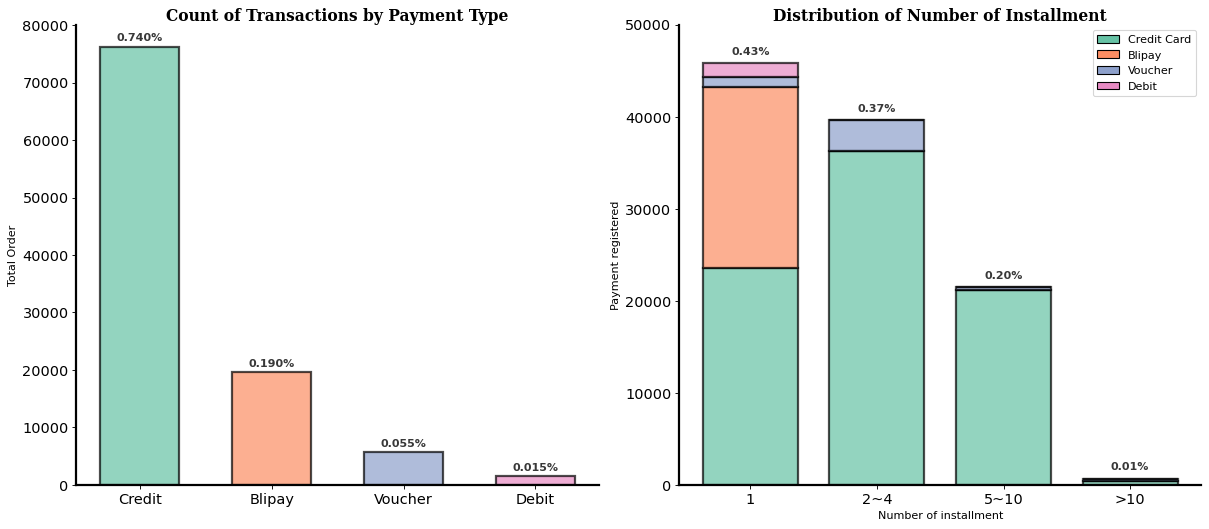

In [26]:
# Color constant : 
colors = sns.color_palette('Set2', n_colors=4)

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 6.5))

# Axis definition
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

x = payment.index.map(lambda label : label.capitalize())
y = payment['total_usage']
ax1.bar(x, y,  color=colors, width=0.6, edgecolor='black', alpha=0.7,linewidth=2)
ax1.set_title(f'Count of Transactions by Payment Type', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_ylabel("Total Order")
# Spine
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.tick_params(axis='y', which='major', labelsize=13)
ax1.tick_params(axis='x', which='major', labelsize=13)

# Annotate
for idx, item in enumerate(x):
    ax1.annotate(f"{y[idx] / sum(y):.3f}%", 
                   xy=(item, y[idx] + 1500),
                   va = 'center', ha='center',fontweight='bold', color='#383838'
                  )

# === Countplot ===
x = ["1", "2~4", "5~10", ">10"]
values_credit = installment_df.loc[installment_df.num_credit_card > 0].total_payment_installment.value_counts()
values_blipay = installment_df.loc[installment_df.num_blipay > 0].total_payment_installment.value_counts()
values_voucher = installment_df.loc[installment_df.num_voucher > 0].total_payment_installment.value_counts()
values_debit = installment_df.loc[installment_df.num_debit > 0].total_payment_installment.value_counts()
y1 = np.array([values_credit[1], sum(values_credit[2:5].values), sum(values_credit[5:11].values), sum(values_credit[11:].values)])
y2 = np.array([values_blipay[1], sum(values_blipay[2:5].values), sum(values_blipay[5:11].values), sum(values_blipay[11:].values)])
y3 = np.array([values_voucher[1], sum(values_voucher[2:5].values), sum(values_voucher[5:11].values), sum(values_voucher[11:].values)])
y4 = np.array([values_debit[1], sum(values_debit[2:5].values), sum(values_debit[5:11].values), sum(values_debit[11:].values)])
ax2.bar(x, y1, color=colors[0], width=0.75, edgecolor='black', alpha=0.7, linewidth=2, label="Credit")
ax2.bar(x, y2, bottom=y1, color=colors[1], width=0.75, edgecolor='black', alpha=0.7, linewidth=2, label="Blipay")
ax2.bar(x, y3, bottom=y1+y2, color=colors[2], width=0.75, edgecolor='black', alpha=0.7, linewidth=2, label="Voucher")
ax2.bar(x, y4, bottom=y1+y2+y3, color=colors[3], width=0.75, edgecolor='black', alpha=0.7, linewidth=2, label="Debit")

ax2.set_title(f'Distribution of Number of Installment', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax2.set_xticks(list(x))
ax2.set_xlabel("Number of installment")
ax2.set_ylabel("Payment registered")

# Formatting
ax2.tick_params(axis='y', which='major', labelsize=13)
ax2.tick_params(axis='x', which='major', labelsize=13)
ax2.spines['bottom'].set_linewidth(2)

# Annotate
y = y1 + y2 + y3 + y4
for idx, item in enumerate(x):
  ax2.annotate(f"{y[idx] / sum(y):.2f}%", 
                  xy=(item, y[idx] + 1250),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )

# Spine
for s in ['top', 'right']:
    ax2.spines[s].set_visible(False)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

legend_elements = [
  Patch(facecolor=colors[0], edgecolor='black', label='Credit Card'), 
  Patch(facecolor=colors[1], edgecolor='black', label='Blipay'),
  Patch(facecolor=colors[2], edgecolor='black', label='Voucher'), 
  Patch(facecolor=colors[3], edgecolor='black', label='Debit')
]
ax2.legend(handles=legend_elements,loc='upper right', ncol=1)

# Limit
ax2.set_ylim(0, 50000)

plt.savefig("../reports/visualization/payment-type1.png")
plt.show()

---

<font size=-1><i>
As we can see from pie chart figure above, nearly 74% payment that were recorded is from credit card usage, 19% payment from Blipay, 5.5 % payment from voucher and the remaining is from debit usage.
<br>
One of the reason why the payment registered in our ecommerce were more than the order registered is the installment option provided by our ecommerce. From the barplot, we can see that most of the time, the number of installment per order is about 1 ~ 4, and only few order took more than 10 installment to be paid off.

</i></font>

---

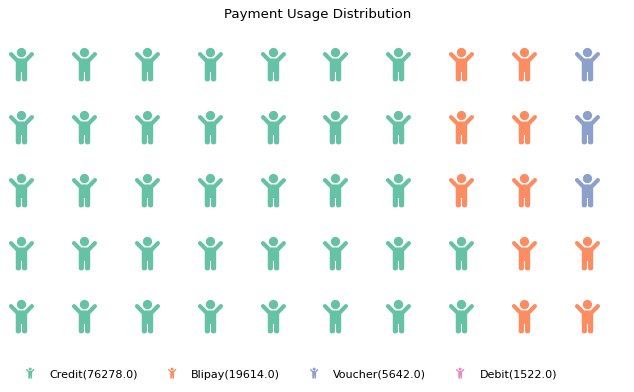

In [27]:
# === Distribution
from pywaffle import Waffle
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10,
    values=payment['total_usage'],
    colors = colors,
    title={'label': 'Payment Usage Distribution', 'loc': 'center'},
    labels=["{}({})".format(a, b) for a, b in zip(payment.index.map(lambda label : label.capitalize()), payment['total_usage']) ],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'ncol': len(payment), 'framealpha': 0},
    font_size=30, 
    icons = 'child',
    figsize=(15, 5),  
    icon_legend=True
)

---

<font size=-1><i>
Above figure show a simple representation of our user. If we represent all of order done in our e-commerce to be done by 50 people, 10 will choose to use blipay, 2 will choose to use voucher, 1 will choose to use debit, and the other 37 will choose to use credit card (debit usage are too few to be sampled).  

</i></font>

---

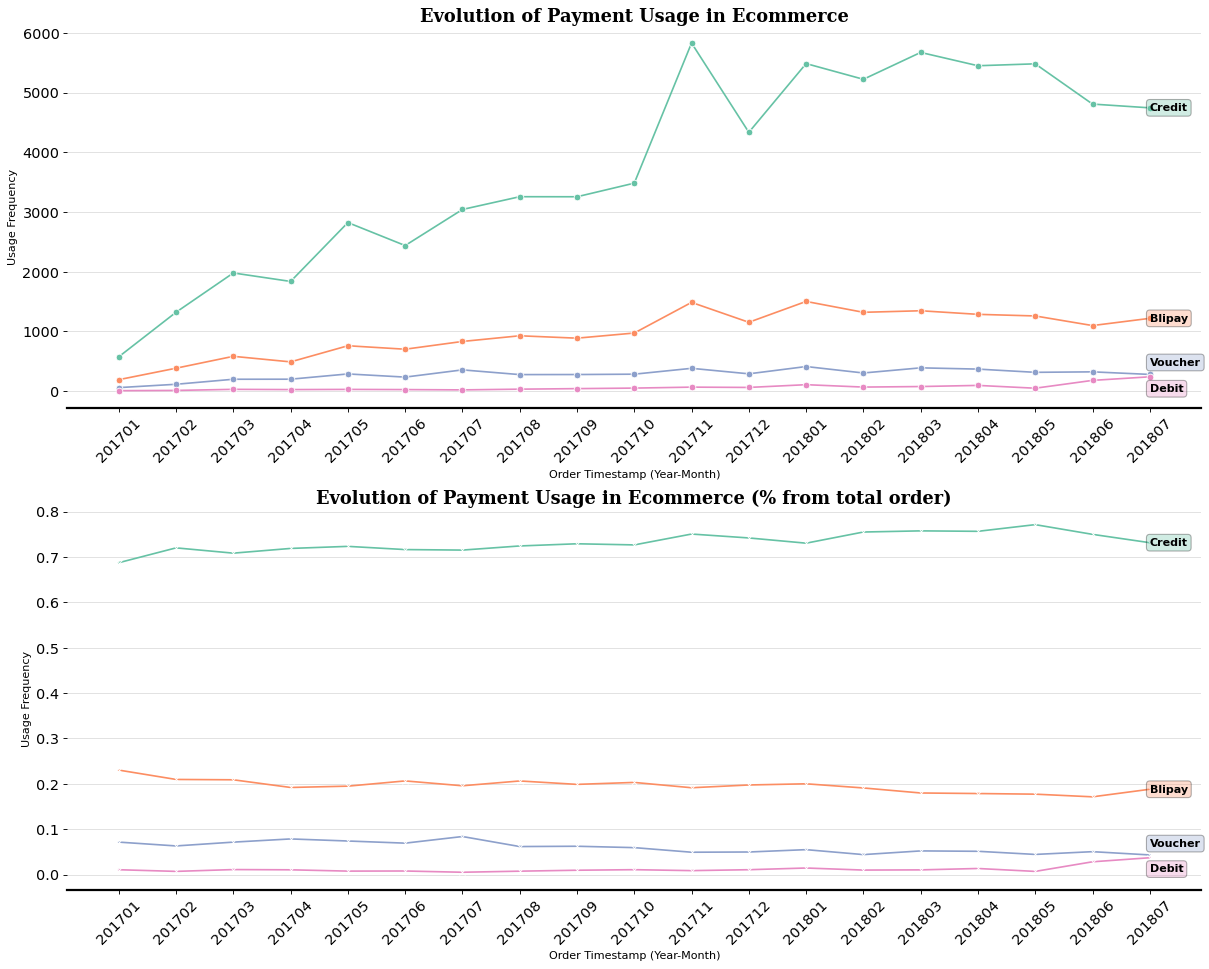

In [28]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

# Plot 3 - Evolution of payment types
evo_df = evo_df.loc[(evo_df['order_date'] >= '2017-01-01') & (evo_df['order_date'] < '2018-08-01') ]
evo_grouped=evo_df.groupby('order_year_month').agg(
    {'num_credit_card':'sum', 'num_blipay':'sum', 'num_voucher':'sum', 'num_debit':'sum' }
  ).rename(columns={'num_blipay':'freq_blipay', 'num_credit_card' : 'freq_credit_card', 
                    'num_debit':'freq_debit', 'num_voucher' : 'freq_voucher'}).reset_index()

# Based from previous analysis, we only take Jan 2017 - August 2018 
evo_melted = evo_grouped.melt('order_year_month', var_name='Type',  value_name='vals')
sns.lineplot(x="order_year_month", y="vals", hue='Type', data=evo_melted, ax=ax1, marker='o', legend=None, palette='Set2')
ax1.set_title('Evolution of Payment Usage in Ecommerce',fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_ylabel('Usage Frequency')
ax1.set_xlabel('Order Timestamp (Year-Month)')

# Annotate label
payment_type_map = {
    "freq_blipay" : "Blipay",
    "freq_credit_card" : "Credit",
    "freq_voucher" : "Voucher",
    "freq_debit" : "Debit"
}

# Labelling
for idx, payment_type in enumerate(evo_melted.Type.unique()) :
  x = -1 if payment_type == "freq_debit" else 1 if payment_type == "freq_voucher" else 0
  ax1.text('201807', evo_melted.loc[evo_melted.Type == payment_type]['vals'].values[-1] + (x * 200)  , 
          s=payment_type_map.get(payment_type), fontweight='bold',
          va='center', ha='left', 
          bbox=dict(boxstyle='round,pad=0.3', fc=colors[idx], ec='black', alpha=0.3))

# Spine
for s in ['top', 'left', 'right']:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)
ax1.spines['bottom'].set_linewidth(1.5)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Based on percentage
evo_grouped_pctg = evo_grouped.copy()
evo_grouped_pctg['all'] = evo_grouped_pctg['freq_debit'] + evo_grouped_pctg['freq_blipay'] + \
                          evo_grouped_pctg['freq_credit_card'] + evo_grouped_pctg['freq_voucher']
evo_grouped_pctg['pctg_credit_card'] = evo_grouped['freq_credit_card'] / evo_grouped_pctg['all']
evo_grouped_pctg['pctg_debit'] = evo_grouped['freq_debit'] / evo_grouped_pctg['all']
evo_grouped_pctg['pctg_blipay'] = evo_grouped['freq_blipay'] / evo_grouped_pctg['all']
evo_grouped_pctg['pctg_voucher'] = evo_grouped['freq_voucher'] / evo_grouped_pctg['all']

evo_grouped_pctg = evo_grouped_pctg[['order_year_month', 'pctg_credit_card', 'pctg_blipay', 'pctg_voucher', 'pctg_debit']]

evo_melted_pctg = evo_grouped_pctg.melt('order_year_month', var_name='Type',  value_name='vals')
sns.lineplot(x="order_year_month", y="vals", hue='Type', data=evo_melted_pctg, ax=ax2, marker='x', legend=None, palette="Set2")
ax2.set_title('Evolution of Payment Usage in Ecommerce (% from total order)',fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')
ax2.set_ylabel('Usage Frequency')
ax2.set_xlabel('Order Timestamp (Year-Month)')

# Annotate label
payment_type_map = {
    "pctg_blipay" : "Blipay",
    "pctg_credit_card" : "Credit",
    "pctg_voucher" : "Voucher",
    "pctg_debit" : "Debit"
}

# Labelling
for idx, payment_type in enumerate(evo_melted_pctg.Type.unique()) :
  x = -0.025 if payment_type == "pctg_debit" else 0.025 if payment_type == "pctg_voucher" else 0
  ax2.text('201807', evo_melted_pctg.loc[evo_melted_pctg.Type == payment_type]['vals'].values[-1] + x  , 
          s=payment_type_map.get(payment_type), fontweight='bold',
          va='center', ha='left', 
          bbox=dict(boxstyle='round,pad=0.3', fc=colors[idx], ec='black', alpha=0.3))

# Spine
for s in ['top', 'left', 'right']:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)
ax2.spines['bottom'].set_linewidth(1.5)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)

# Formatting
for ax in [ax1,ax2]:
  # Spine
  ax.spines['bottom'].set_linewidth(2)
  # Ticklabels
  ax.tick_params(axis='y', which='major', labelsize=13)
  ax.tick_params(axis='x', which='major', labelsize=13)

plt.savefig("../reports/visualization/payment-type2.png")
plt.show()

***
<font size=-1><i>
From the line chart, we can see that the majority of payment is done using credit card. But from <b>March 2018</b>, we can see that the usage on this payment is slightly reduced, meanwhile the usage of blipay is steadily increasing along the time. From <b> May 2018</b> the payment using debit card is slightly increasing, might be useful it we check the opportunity to invest and improve in this payment service.
<br>
From the evolution point itself, I try to calculate the percentage use of payment per month. From May 2018, we could see a slight upward trend from Debit usage, while credit have slight downward trend.
</i></font>

***

***
<font size=-1><i>
When answering previous question, a new question comes up to me. What is the <b>characteristic (payment value)</b> of each payment type? Based on the data available, I'm going to try to see the different for the average value for each payment, and each installment
</i></font>

***

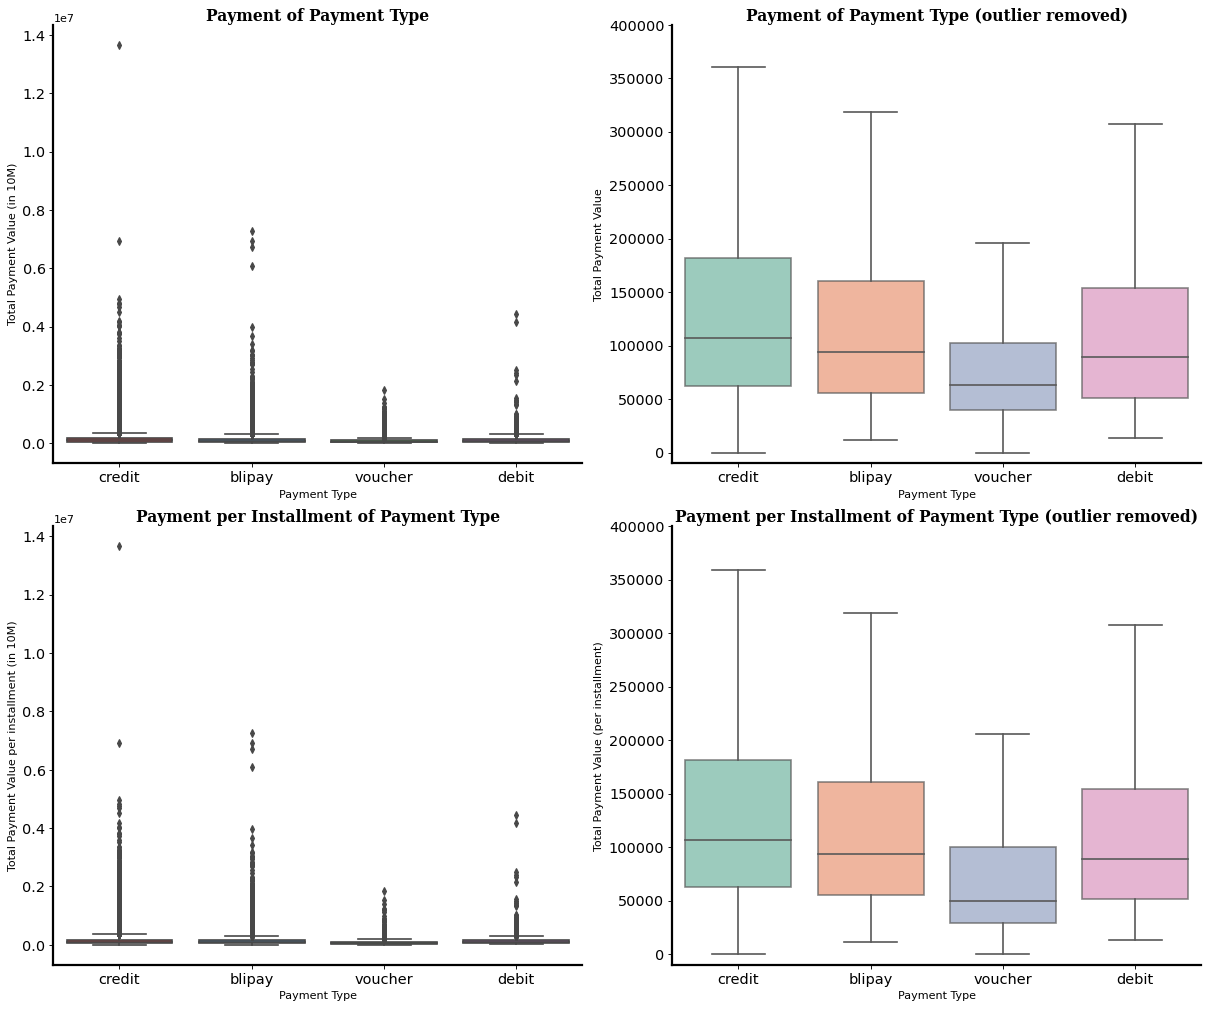

In [29]:
# Transforming Data

# Blipay Transformation
blipay_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "num_payment" : [],
    "per_installment_payment" : [],
    "type":[]
})
blipay_total_transaction.total_payment = df.loc[df.num_blipay > 0].total_payment_blipay
blipay_total_transaction.num_payment = df.loc[df.num_blipay > 0].num_blipay
blipay_total_transaction.per_installment_payment = df.loc[df.num_blipay > 0].payment_per_installment_blipay
blipay_total_transaction.type = "blipay"

# Credict card transformation
credit_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "num_payment" : [],
    "per_installment_payment" : [],
    "type":[]
})
credit_total_transaction.total_payment = df.loc[df.num_credit_card > 0].total_payment_credit_card
credit_total_transaction.num_payment = df.loc[df.num_credit_card > 0].num_credit_card
credit_total_transaction.per_installment_payment = df.loc[df.num_credit_card > 0].payment_per_installment_credit
credit_total_transaction.type = "credit"

# Debit transformation
debit_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "num_payment" : [],
    "per_installment_payment" : [],
    "type":[]
})
debit_total_transaction.total_payment = df.loc[df.num_debit > 0].total_payment_debit
debit_total_transaction.num_payment = df.loc[df.num_debit > 0].num_debit
debit_total_transaction.per_installment_payment = df.loc[df.num_debit > 0].payment_per_installment_debit
debit_total_transaction.type = "debit"

# Voucher Transformatuon
voucher_total_transaction = pd.DataFrame({
    "total_payment" : [],
    "num_payment" : [],
    "per_installment_payment" : [],
    "type":[]
})
voucher_total_transaction.total_payment = df.loc[df.num_voucher > 0].total_payment_voucher
voucher_total_transaction.num_payment = df.loc[df.num_voucher > 0].num_voucher
voucher_total_transaction.per_installment_payment = df.loc[df.num_voucher > 0].payment_per_installment_voucher
voucher_total_transaction.type = "voucher"

total_transaction = pd.concat([credit_total_transaction,blipay_total_transaction,voucher_total_transaction, debit_total_transaction], ignore_index=True)

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 18))

# Axis definition
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1,1])

# Boxplot for total transaction using each type of payment

sns.boxplot(x="type", y="total_payment", ax=ax1,
                   data=total_transaction, palette="Set1")
ax1.set_title('Payment of Payment Type',fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_ylabel('Total Payment Value (in 10M)')
ax1.set_xlabel('Payment Type')


sns.boxplot(x="type", y="total_payment", ax=ax2,
                   data=total_transaction, palette="Set2", showfliers=False, boxprops=dict(alpha=.7))
ax2.set_ylim(-10000, 400000)
ax2.set_title('Payment of Payment Type (outlier removed)',fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax2.set_ylabel('Total Payment Value')
ax2.set_xlabel('Payment Type')

# Spine
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

sns.boxplot(x="type", y="per_installment_payment", ax=ax3,
                   data=total_transaction, palette="Set1")
ax3.set_title('Payment per Installment of Payment Type',fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax3.set_ylabel('Total Payment Value per installment (in 10M)')
ax3.set_xlabel('Payment Type')

sns.boxplot(x="type", y="per_installment_payment", ax=ax4,
                   data=total_transaction, palette="Set2", showfliers=False, boxprops=dict(alpha=.7))
ax4.set_ylim(-10000, 400000)
ax4.set_title('Payment per Installment of Payment Type (outlier removed)',fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax4.set_ylabel('Total Payment Value (per installment)')
ax4.set_xlabel('Payment Type')

# Formatting
for ax in [ax1,ax2,ax3,ax4]:
  # Spine
  ax.spines['bottom'].set_linewidth(2)
  ax.spines['left'].set_linewidth(2)
  # Ticklabels
  ax.tick_params(axis='y', which='major', labelsize=13)
  ax.tick_params(axis='x', which='major', labelsize=13)
  # Spine
  for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

plt.savefig("../reports/visualization/payment-type3.png")
plt.show()

***
<font size=-1><i>
Based on the boxplot, we could see many outlier from credit, blipay and debit for each transaction (order). From the outlier, we could see that most likely people will use either credit card for high value transaction.
<br>
From the boxplot with outlier removed, we can see that for high value (price) order, user usually pay with credit card. This might make sense, since credit card usually give cashback (or any other benefit) and you can pay later to the credit card bank. Meanwhile for low value (price) order, user usually pay with voucher (around 78k)
Here, we see that for each installment, credit card still have the most value for payment, followed by blipay and credit. 
<br>
To see the difference between each payment type value distribution, please kindly check ridgeplot below ...
</i></font>

***

<font color="slategray" size=+0.5><b>Insight</b></font>

<font size=-1>
<i>
As final takeaway, here are the things that we need to look out for : 
<ul>
  <font size=-1>
  <li>The most <b>preferred</b> way of paying is by using <b>credit card</b> followed by <b>blipay</b>.</li>
  <li>It seems there are many <b>high value</b> payment using blipay & credit card transaction occurs in our ecommerce.</li>
  <li>For high value (based on payment value) order, user usually pay with credit card.  Meanwhile for low value (based on payment value) order, user usually pay with voucher</li>
  <li>Transaction using blipay is also multimodal (can be for high & low value order), and seems like for lesser value even though still dominated by outliers.</li>
  <li>Debit and voucher are not used much as the other payment method. But there are some increasing usage in debit type payment from May 2018, it is worth to dig in further.</li>
  </font>
</ul>
</i></font>

<font color="slategray" size=+0.5><b>Recommendation</b></font>

<font size=-1><i>
Based on insight that we get from the payment analysis, we can recommend few things:
<ul>
  <font size=-1>
  <li>If we want to payment method more diverse in our ecommerce, we should try to give special discount when using debit / blipay, to increase usage of other payment method.</li>
  <li>Because there are an increasing trend to use digital wallet in Indonesia, we might be able to give some "cashback" when user use blipay or other digital wallet by collaborating with big digital wallet company. The benefit that we can give to them are increasing likelyhood of user welcoming the use of digital wallet</li>
  <li>As many user welcome ecommerce, we can see 1 of the main problem that is cart abondonment in checkout process. One of the reason of this problem is because the ecommerce don't provide the payment method that they prefered. While this analysis don't provide payment method that were not being used by our ecommerce, we can do payment method analysis from other ecommerce  to decrease the abondonment rates in checkout process because of payment method. One of the strategy that we can do are by applying A/B Testing E-Payment Methods to find out the new more prefered payment method for this ecommerce. ( Lower abandonment rate, Reduced customer acquisition cost and increase profit)</li>
  <li>The Ecommerce can try to find out which credit card bank that the user use to improve the service by partnering with the bank (providing more detail about the credit card)</li>
  <font>
</ul>
</i></font>

## <font color="black" size=+1.5><b>3.3 Recency Analysis</b></font>

<font color="slategray" size=+0.5><b>Purpose</b></font>

<font size=-1><i>
  <ul>
    <li>What is the <b>growth</b> for <b>new user & loyal user</b> for our ecommerce?</li>
    <li>What is the <b>average spending</b> for <b>new user & loyal user</b> for our ecommerce?</li>
    <li>How many user in each <b>recency and monetary segment</b> based on <b>user order behavior</b>?</li>
  </ul>
</i></font>

<font color="slategray" size=+0.5><b>Background</b></font>

<font size=-1>
<i>
In ecommerce, the more we understand the behavior the more efficient action we can take be increase the likelyhood to target our best customer. With this in mind, I'm trying to implement a simple RFM analysis based on our customer data with the end goal to understand more of our customer and able to identify which is our best customer based on simple segmentation from order behaviour.
<br>
<br>
Why is it important to segment our customer? Based on Salesforce, customer segmentation is a process to divide a customer base into groups of individuals that are similar in specific ways relevant to marketing, such as age, gender, interests and spending habits. One way to achieve this process is by segmenting based on RFM Analysis (in this process, I will focus more on the recency and monetary). 
<br>
<br>
By segmenting our customer / user, we can understand more about our user, such as : 
<ul>
<font size=-1>
<li>Who is our best customer in the ecommerce ?</li>
<li>Which customer is in the verge of churning ?</li>
<li>Which customer in the verge of churning that are really valuable?</li>
<li>Which customer in the verge of churning that don't need many attention?</li>
<li>Who are our loyal customer?</li>
<li>Which is our customer that must be retained?</li> 
</font>
</ul>
<br>
The user growth (either new user or returning user) is also as important as categorizing user. By understanding how is the growth on our new user and returning user, we can plan new marketing plan that can furthur impact those area or to improve things in the ecommerce that can boost user satisfaction.
<br>
<br>
<b>Remember! The transaction isn’t over after they click “Purchase”.</b> When we get new customer but you’ll leave a lot more on the table if you stop there. Repeat customers tends to spend more on average than first-timers, and because all your marketing costs were sunk in acquiring them in the first place, that extra spend is almost pure profit. That's why by analyzing our current customer, we can improve our service to make more repeat customer.

</i></font>

<font color="slategray" size=+0.5><b>In General & Assumption</b></font>
<font size=-1><i>

For this analysis, I will try to approach the problem based on user recency & monetary since most user have only been using our ecommerce for first time (or only one time). Also since that the location (delivery order) infer that this ecommerce is more likely located in Indonesia, I will use information about ecommerce in Indonesia to compare our ecommerce with most of the ecommerce located in Indonesia
</i></font>

In [30]:
LIFETIME_QUERY = """
select 
	u.user_name,
	MAX(foi.lifetime_order) as lifetime_order ,
	MAX(foi.lifetime_spending) as lifetime_spending,
  MAX(foi.lifetime_spending) / MAX(foi.lifetime_order) as avg_lifetime_spending
from staging.fct_order_items foi
left join (
	select 
		du.user_key ,
		du.user_name 
	from staging.dim_user du 
	where du.is_current_version=true
) u on foi.user_key = u.user_key
left join staging.dim_date dd on foi.order_date = dd.date_id 
group by u.user_name
"""

SPENDING_QUERY = """
select 
	u.user_name,
  dd.year,
  MAX(foi.lifetime_spending) / MAX(foi.lifetime_order) as avg_lifetime_spending
from staging.fct_order_items foi
left join (
	select 
		du.user_key ,
		du.user_name 
	from staging.dim_user du 
	where du.is_current_version=true
) u on foi.user_key = u.user_key
left join staging.dim_date dd on foi.order_date = dd.date_id 
group by u.user_name, dd.year
"""

INTERVAL_QUERY = """
select 
distinct
	foi.order_id,
	u.user_name,
	dd.date ,
  foi.total_payment_value
from staging.fct_order_items foi 
left join (
	select 
		du.user_key ,
		du.user_name 
	from staging.dim_user du 
	where du.is_current_version=true
) u on foi.user_key = u.user_key
left join staging.dim_date dd on foi.order_date = dd.date_id 
left join staging.dim_time dt on foi.order_time = dt.time_id
where foi.lifetime_order > 1;
"""

RFM_QUERY = """
select 
	u.user_name,
  u.customer_state,
	DATE_PART('day', '2018-09-03'::timestamp- MAX(dd."date")) as recency,
	MAX(foi.lifetime_order) as frequency ,
	MAX(foi.lifetime_spending) as monetary,
	MAX(dd."date") - MIN(dd."date") as usage_days,
  MAX(foi.lifetime_spending) as total_spending,
	MAX(foi.lifetime_spending) / MAX(foi.lifetime_order) as average_order_value,
    COUNT(foi.order_item_id)  as total_basket_size,
    COUNT(foi.order_item_id) / MAX(foi.lifetime_order)  as avg_basket_size,
    CASE 
        WHEN DATE_PART('day', '2018-09-03'::timestamp- MAX(dd."date")) < 183 THEN 'ACTIVE'
        WHEN DATE_PART('day', '2018-09-03'::timestamp- MAX(dd."date")) >= 183 AND DATE_PART('day', '2018-09-03'::timestamp- MAX(dd."date")) < 365 THEN 'INACTIVE'
        ELSE 'LAPSED'
    END as recency_status
from staging.fct_order_items foi
left join staging.dim_date dd on foi.order_date = dd.date_id 
left join (
	select 
		du.user_key ,
		du.user_name ,
    dg.state as customer_state
	from staging.dim_user du 
  left join staging.dim_geo dg on du.customer_geo_id = dg.geo_id 
	where du.is_current_version=true
) u on foi.user_key = u.user_key
group by u.user_name , u.customer_state
order by 6 desc;
"""

# Data for analyzing lifetime
lifetime_df = pd.read_sql_query(LIFETIME_QUERY, conn)
spending_df = pd.read_sql_query(SPENDING_QUERY, conn)
spending_df.dropna(axis=0, inplace=True)

# Data for analyzing interval
interval_df = pd.read_sql_query(INTERVAL_QUERY, conn)
interval_df['date'] = pd.to_datetime(interval_df['date'], format='%Y-%m-%d')

# Transformation
interval_df['previous_date'] = interval_df.groupby('user_name')['date'].shift(1)
interval_df.dropna(inplace = True)
interval_df['order_interval'] = (interval_df['date'] - interval_df['previous_date']).dt.days
# To get multiple usage, and not in the same day order
interval_df = interval_df[interval_df['order_interval'] > 0]

new_interval_df = pd.read_sql_query(INTERVAL_QUERY, conn)
new_interval_df['date'] = pd.to_datetime(new_interval_df['date'], format='%Y-%m-%d')
new_interval_df['order_year_month'] = new_interval_df['date'].apply(lambda x: x.strftime('%Y%m'))

def transform_interval(df):
  df['previous_date'] = df.groupby('user_name')['date'].shift(1)
  df.dropna(inplace = True)
  df['order_interval'] = (df['date'] - df['previous_date']).dt.days
  df = df[df['order_interval'] > 0]
  return df

def get_growth(df, column):
  df['previous_' + column] = df[column].shift(1)
  df['growth_' + column] = (df[column] - df['previous_' + column]) / df['previous_' + column]
  df['growth_' + column].replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0,inplace=True)
  return df

order_year_months = new_interval_df['order_year_month'].unique()
order_year_months.sort()

returning_users_per_month = []
new_users_per_month = []
returning_users_per_month_spending = []
new_users_per_month_spending = []
# Loop through each month
for order_year_month in order_year_months : 
  temp_df = new_interval_df.loc[new_interval_df['order_year_month'] <= order_year_month]
  returning_df = transform_interval(temp_df)
  returning_user_count = len(returning_df)
  returning_user_spending = sum(returning_df.loc[returning_df['order_year_month'] == order_year_month].total_payment_value.values)
  new_user_count = len(temp_df) - returning_user_count
  new_user_spending = sum(temp_df.loc[temp_df['order_year_month'] == order_year_month].total_payment_value.values) - returning_user_spending
  returning_users_per_month.append(returning_user_count)
  returning_users_per_month_spending.append(returning_user_spending)
  new_users_per_month.append(new_user_count)
  new_users_per_month_spending.append(new_user_spending)

evo_user_df = pd.DataFrame({
    "order_year_month" : order_year_months,
    "new_user_count" : new_users_per_month,
    "returning_user_count" : returning_users_per_month,
    "new_user_spending" : new_users_per_month_spending,
    "returning_user_spending" : returning_users_per_month_spending,
})

evo_user_df = get_growth(evo_user_df, 'new_user_count')
evo_user_df = get_growth(evo_user_df, 'returning_user_count')

rfm_df = pd.read_sql_query(RFM_QUERY, conn)
rfm_df = rfm_df.dropna(subset=['frequency'])

rfm_df['percentile_avg_spending'] = pd.qcut(rfm_df['average_order_value'], 10, labels=np.arange(1, 11, 1)).astype('int')
rfm_df['percentile_total_spending'] = pd.qcut(rfm_df['total_spending'], 10, labels=np.arange(1, 11, 1)).astype('int')
rfm_df['volume_type'] = rfm_df.apply(
    lambda row : "High Volume" if row['avg_basket_size'] > 1 else "Low Volume",
    axis = 1
)
rfm_df['spending_type'] = rfm_df.apply(
    lambda row : "Low Value" if row['percentile_avg_spending'] < 6 else "High Value"
    , axis = 1
)

rfm_df['segment'] = rfm_df.apply(lambda row : f"{row.spending_type} & {row.volume_type}" , axis = 1)

# Prepare Data
PRODUCT_CAT_QUERY = """
select 
	foi.order_id ,
	du.user_name ,
	dp.product_category 
from staging.fct_order_items foi 
left join staging.dim_product dp on dp.product_key = foi.product_key 
left join staging.dim_user du on du.user_key = foi.user_key 
"""
prod_cat_df = pd.read_sql_query(PRODUCT_CAT_QUERY, conn)
hvhv_cust = rfm_df.loc[rfm_df.segment == "High Value & High Volume"].user_name.values
lvhv_cust = rfm_df.loc[rfm_df.segment == "Low Value & High Volume"].user_name.values
hvlv_cust = rfm_df.loc[rfm_df.segment == "High Value & Low Volume"].user_name.values
lvlv_cust = rfm_df.loc[rfm_df.segment == "Low Value & Low Volume"].user_name.values

hvhv_values = prod_cat_df.loc[prod_cat_df.user_name.isin(hvhv_cust)].product_category.value_counts()
lvhv_values = prod_cat_df.loc[prod_cat_df.user_name.isin(lvhv_cust)].product_category.value_counts()
hvlv_values = prod_cat_df.loc[prod_cat_df.user_name.isin(hvlv_cust)].product_category.value_counts()
lvlv_values = prod_cat_df.loc[prod_cat_df.user_name.isin(lvlv_cust)].product_category.value_counts()

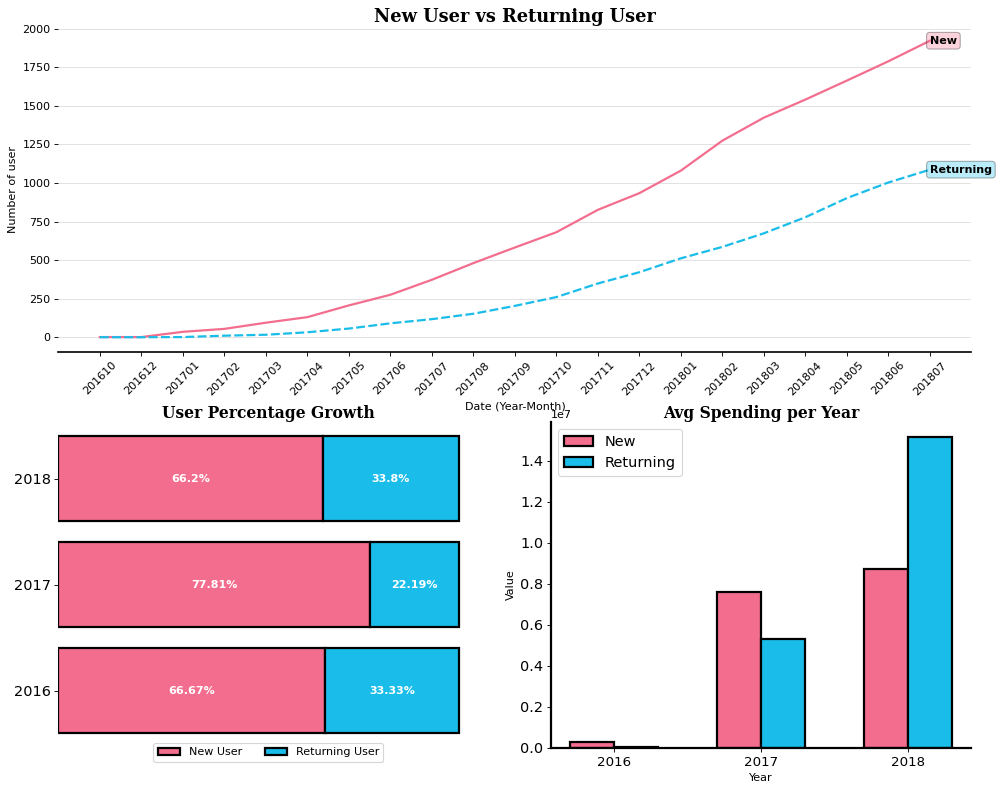

In [31]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# === Deleted content ===
# Annotation - New User Average Growth Rate Along the Year for Ecommerce User
# ax1.text(0.50, 0.50, f'{round(100 * evo_user_df.growth_new_user_count.mean(), 2)} %', fontsize=45, ha='center')
# ax1.text(0.50, 0.3, 'is the mean value of new user growth', fontsize=14, ha='center')
# ax1.text(0.50, 0.1, 'for our ecommerce (2016 - 2018)', fontsize=14, ha='center')
# ax1.axis('off') 

# # Annotation - Returning User Average Growth Rate Along the Year for Ecommerce User
# ax2.text(0.50, 0.5, f'{round(100 * evo_user_df.growth_returning_user_count.mean(), 2)} %', fontsize=45, ha='center')
# ax2.text(0.50, 0.3, 'is the mean value of returning user growth', fontsize=14, ha='center')
# ax2.text(0.50, 0.1, 'for our ecommerce (2016 - 2018)', fontsize=14, ha='center')
# ax2.axis('off') 

# == 
temp_df = evo_user_df[['order_year_month','new_user_count', 'returning_user_count']].loc[evo_user_df.order_year_month < '201808']
temp_df.set_index('order_year_month', inplace=True)

sns.lineplot(ax=ax1, data=temp_df, palette=[color1, color2], linewidth=2,legend=False)
ax1.set_title("New User vs Returning User", fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_xlabel("Date (Year-Month)")
ax1.set_ylabel("Number of user")

# Labelling
user_map = {
    'new_user_count' : "New",
    "returning_user_count" : "Returning"
} 
for idx, user in enumerate(['new_user_count', 'returning_user_count']) :
  ax1.text('201807',  temp_df[user].values[-1], 
          s=user_map[user], fontweight='bold',
          va='center', ha='left', 
          bbox=dict(boxstyle='round,pad=0.3', fc=[color1, color2][idx], ec='black', alpha=0.3))

# Spine
for s in ['top', 'left', 'right']:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)
ax1.spines['bottom'].set_linewidth(1.5)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# === Percentage ===
# Bar chart - Comparison between monthly sales between 2017 and 2018
percent_df = temp_df.div(temp_df.sum(1).astype(float), axis=0).reset_index()
percent_df['year'] = percent_df['order_year_month'].apply(lambda val : str(val)[:4])
res = percent_df.groupby(['year']).agg(
    new_user_count=('new_user_count', 'mean'),
    returning_user_count = ('returning_user_count', 'mean')
  ).reset_index()
year_label = [2016, 2017, 2018]
x = np.arange(len(year_label)) 
y1 = res.new_user_count.values
y2 = res.returning_user_count.values
width=0.5

# First Bar Plot
ax2.barh(x, y1/(y1+y2), 
       color=color1,
       edgecolor='black',
       linewidth=2,
       label='New User'
      )

# Second Bar Plot
ax2.barh(x, y2/(y1+y2), left=y1/(y1+y2), 
       color=color2,
       edgecolor='black',
       linewidth=2,
       label='Returning User'
      )

# Spine
for s in ['top', 'bottom', 'left', 'right']:
    ax2.spines[s].set_visible(False)

# Annotate scoring 
for xx, yy1, yy2 in zip(x, y1, y2):
  score = 100*yy1/(yy1+yy2)
  if score > 5 :
    ax2.annotate(f"{score:.4}%", 
                    xy=(yy1/(yy1+yy2)/2, xx),
                    va = 'center', ha='center',fontsize=10, fontweight='bold',
                    color='white')
  score = 100*yy2/(yy1+yy2)
  if score > 5 : 
    ax2.annotate(f"{score:.4}%", 
                xy=((1+(yy1)/(yy1+yy2))/2, xx),
                va = 'center', ha='center',fontsize=10, fontweight='bold',
                color='white')

# Legend & Ticks
ax2.set_title('User Percentage Growth', loc='center', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax2.set_xticks([])
ax2.set_yticks(x)
ax2.set_yticklabels(year_label, fontsize=12)
ax2.tick_params(axis='y', which='major', labelsize=13)
ax2.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# === Boxplot ===
spending_box_df = evo_user_df[['order_year_month','new_user_spending', 'returning_user_spending']].loc[evo_user_df.order_year_month < '201808']
spending_box_df['year'] = spending_box_df['order_year_month'].apply(lambda val : str(val)[:4])
# spending_box_df.columns = [spending_box_df.columns[0]] + ['New', 'Returning'] + [spending_box_df.columns[-1]]
# spending_box_df[spending_box_df.columns[1:]].melt('year', var_name='Type',  value_name='vals')
res = spending_box_df.groupby(['year']).agg(
    new_user_spending=('new_user_spending', 'mean'),
    returning_user_spending = ('returning_user_spending', 'mean')
  ).reset_index()

x = np.arange(len(year_label)) 
y1 = res.new_user_spending.values
y2 = res.returning_user_spending.values
width=0.3

# Sky Bar Plot
ax3.bar(x-width/2, y1, 
       color=color1,
       edgecolor='black',
       linewidth=2,
       width=width,
       label='New'
      
      )

# Pink Bar Plot
ax3.bar(x+width/2, y2, 
       color=color2,
       edgecolor='black',
       linewidth=2,
       width=width,
       label='Returning'
      )


# Spine
ax3.spines['bottom'].set_linewidth(2)
ax3.spines['left'].set_linewidth(2)

#### Text #### 

# Title
ax3.set_title("Avg Spending per Year", loc='center', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')

# Label
ax3.set_xlabel("Year", fontsize=10, fontweight='medium')
ax3.set_ylabel("Value", fontsize=10, fontweight='medium')

# Ticklabels
ax3.set_xticks(x)
ax3.set_xticklabels(year_label, fontsize=12)
ax3.tick_params(axis='y', which='major', labelsize=13)

# Legend 
ax3.legend(fontsize=13)

# Spine
for s in ['top', 'right']:
    ax3.spines[s].set_visible(False)

plt.savefig("../reports/visualization/rfm-trend1.png")
plt.tight_layout()
plt.show()


---
<font size=-1><i>
Using above plot, we can see that : 
<ul>
<font size=-1>
  <li>The average for new user growth each month for our ecommerce is about <b>68.3%</b> (early - mid 2016 & late 2018)</li>
  <li>The average for returning user growth each month for our ecommerce is about <b>41.53%</b> (early - mid 2016 & late 2018)</li>
  <li>Based on the line plot, we can see that both new user and returning user for our ecommerce is steadily increasing (which is awesome!!)</li>
  <li>From user percentage growth between new user and returning user, we can see that 2017 might be the best year for new user in our ecommerce. Part of the reason might be because there are peak season in November 2017 (remember the legendary Black Friday)</li>
  <li>From the average spending chart itself, we can see that along the time, returning user spend more than new user. This is one of the reason why we must make sure that returning user will keep using our service</li>
</font>
</ul>
ps : Returning user is counted from user that have order from past (minimum 1 days before)
</i></font>

---

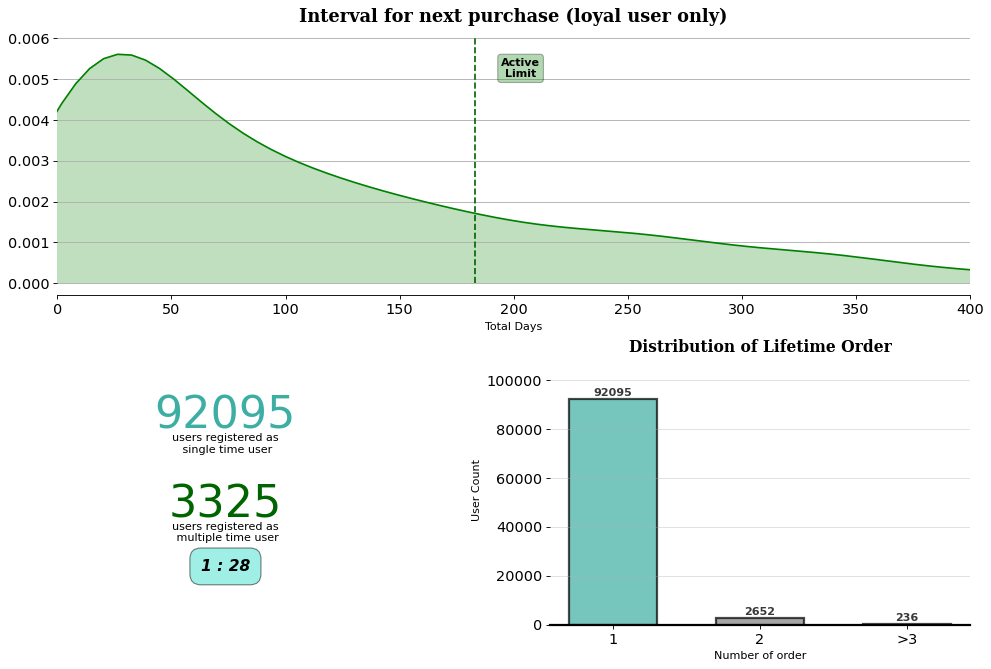

In [32]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# === Distplot === 
ax1.set_title('Interval for next purchase (loyal user only)',fontsize=16, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_xlabel('Total Days')
ax1.set_xlim(0, 400)
# you can also draw density plot with matplotlib + scipy.
upper_bound_lim = 183
sns.kdeplot(interval_df[interval_df['order_interval'] > 0].order_interval, 
            ax=ax1,color="green", legend=None, shade=True) 
ax1.vlines(upper_bound_lim, ymin=0, ymax=0.006, linestyle='--', color="darkgreen")

ax1.text(upper_bound_lim + 20, 0.005, s="Active\nLimit", fontweight='bold',
         va='bottom', ha='center', 
         bbox=dict(boxstyle='round,pad=0.3', fc="green", ec='black', alpha=0.3))

# Spine
for s in ['top', 'left', 'right']:
    ax1.spines[s].set_visible(False)
ax1.grid(which='major', axis='y')

# === Annotation ===
single =  len(lifetime_df.loc[lifetime_df.lifetime_order == 1])
multiple = len(lifetime_df) - single
ratio = round(single/multiple)
ax2.text(0.40, 0.73, f'{single}', fontsize=40, color='#3caea3', ha='center')
ax2.text(0.40, 0.64, 'users registered as\n single time user', fontsize=10, ha='center')
ax2.text(0.40, 0.40, f'{multiple}', fontsize=40, color='darkgreen', ha='center')
ax2.text(0.40, 0.31, 'users registered as\n multiple time user', fontsize=10, ha='center')
ax2.text(0.40, 0.20, f'1 : {ratio}', fontsize=14, ha='center', color='black', style='italic', weight='bold',
         bbox=dict(facecolor='#40E0D0', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# === Countplot (User Count)===
x = ["1", "2", ">3"]
values = lifetime_df.lifetime_order.value_counts()
y = [values[1], values[2], sum(values[3:].values)]
ax3.bar(x, y,  color=['#3caea3', 'gray', 'gray'], width=0.6, edgecolor='black', alpha=0.7,linewidth=2)
ax3.set_title(f'Distribution of Lifetime Order', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax3.set_xticks(list(x))
ax3.set_xlabel("Number of order")
ax3.set_ylabel("User Count")

# Annotate
for idx, item in enumerate(x):
  ax3.annotate(f"{y[idx]}", 
                  xy=(item, y[idx] + 2500),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )

# Spine
for s in ['top', 'left', 'right']:
    ax3.spines[s].set_visible(False)

# Limit
ax3.set_ylim(0, 110000)
ax3.grid(axis='y', linestyle='-', alpha=0.4)

# Spine
ax3.spines['bottom'].set_linewidth(2)
ax3.spines['left'].set_linewidth(2)

for ax in [ax1,ax3]:
  ax.tick_params(axis='y', which='major', labelsize=13)
  ax.tick_params(axis='x', which='major', labelsize=13)

plt.savefig("../reports/visualization/rfm-trend2.png")
plt.tight_layout()
plt.show()

---

<font size=-1><i>
Using above plot, we can see some facts about our customer : 
<ul>
<font size=-1>
  <li>We have <b>1:28</b> ratio of returning user vs new user. It means that for every 29 new user, one of the would be our loyal customer, the rest will be churned </li>
  <li>Most user (around 92k) only purchase 1 times from the ecommerce. Meanwhile, there are about (~ 3k) user that purchase more than 1 times.</li>
  <li>Majority of customers who repurchase order leave between 22 and 168 days to do so. The upper quartile (Q3) suggests that there is a rough interval of 183 days which sits about 6 months.</li>
  
</font>
</ul>
<br>
By using the upper bound of that interval, we can have this as our cut-off point for recency, ultimately any purchase within 6 months (~183 days) will be considered as a recent purchase. Using this recency cutoff duration, we can segment our customer based on the recency of last purchase

</i></font>

---

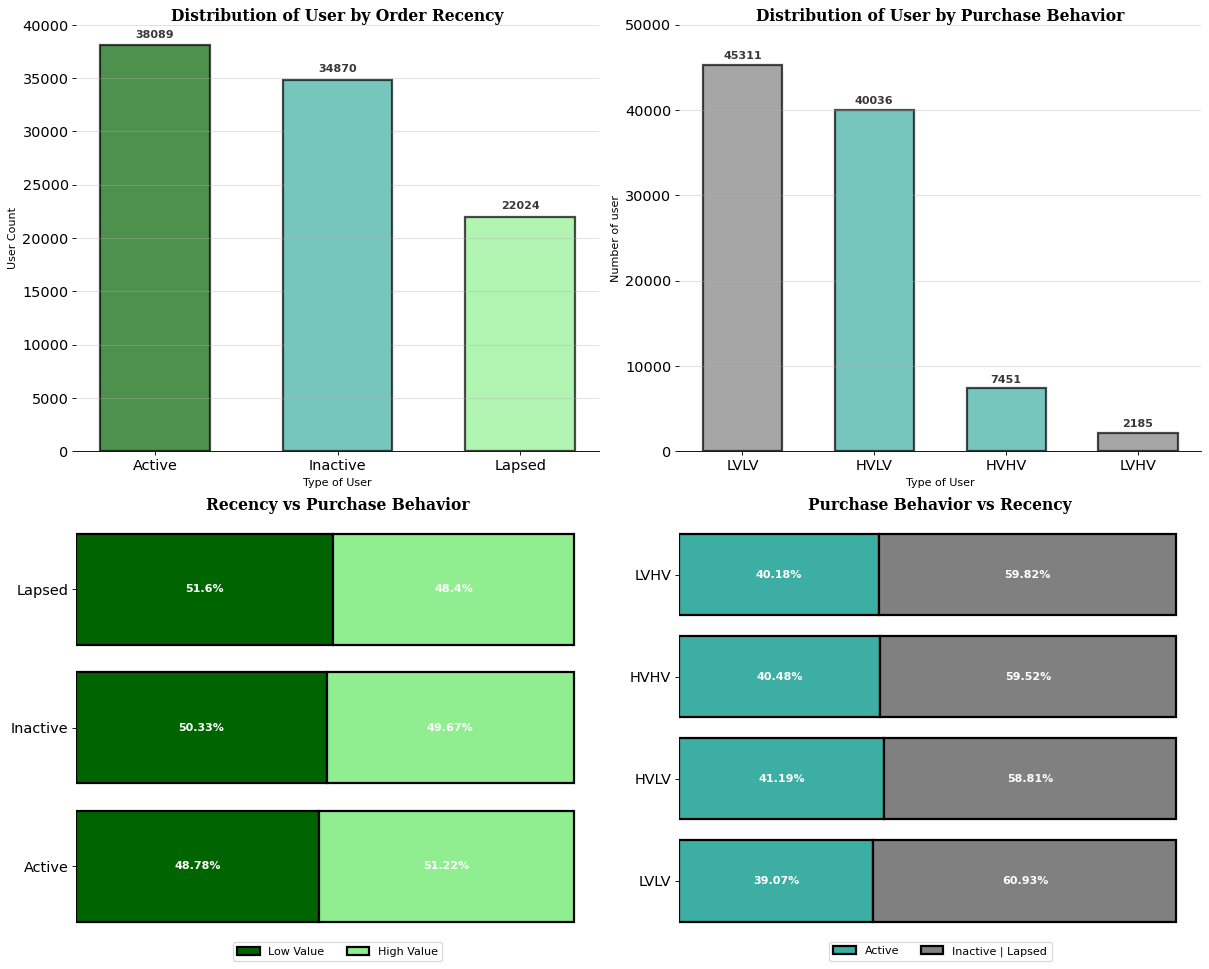

In [33]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

colors = ['darkgreen', '#3caea3', 'lightgreen']

# === Countplot (User Count)===
x = ["Active", "Inactive", "Lapsed"]
values = rfm_df.recency_status.value_counts()
y = [values["ACTIVE"], values["INACTIVE"], values["LAPSED"]]
ax1.bar(x, y,  color=colors, width=0.6, edgecolor='black', alpha=0.7,linewidth=2)
ax1.set_title(f'Distribution of User by Order Recency', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_xticks(list(x))
ax1.set_xlabel("Type of User")
ax1.set_ylabel("User Count")

# Annotate
for idx, item in enumerate(x):
  ax1.annotate(f"{y[idx]}", 
                  xy=(item, y[idx] + 1000),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )

# Spine
for s in ['top', 'left', 'right']:
    ax1.spines[s].set_visible(False)

# Limit
ax1.set_ylim(0, 40000)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

# === Countplot (User Count)===
x = ["LVLV", "HVLV", "HVHV", "LVHV"]
values = rfm_df.segment.value_counts()
y = [values["Low Value & Low Volume"], values["High Value & Low Volume"], values["High Value & High Volume"], values["Low Value & High Volume"]]
ax2.bar(x, y,  color=["gray", "#3caea3","#3caea3","gray" ], width=0.6, edgecolor='black', alpha=0.7,linewidth=2)
ax2.set_title(f'Distribution of User by Purchase Behavior', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax2.set_xticks(list(x))
ax2.set_xlabel("Type of User")
ax2.set_ylabel("Number of user")

# Annotate
for idx, item in enumerate(x):
  ax2.annotate(f"{y[idx]}", 
                  xy=(item, y[idx] + 1000),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )

# Spine
for s in ['top', 'left', 'right']:
    ax2.spines[s].set_visible(False)

# Limit
ax2.set_ylim(0, 50000)
ax2.grid(axis='y', linestyle='-', alpha=0.4)


for ax in [ax1, ax2]:
  ax.tick_params(axis='y', which='major', labelsize=13)
  ax.tick_params(axis='x', which='major', labelsize=13)

# === Percentage ===
# Bar chart - Comparison between monthly sales between 2017 and 2018
recency_label = ["Active", "Inactive", "Lapsed"]
segment_type = ["Low Value & Low Volume", "High Value & Low Volume", "High Value & High Volume", "Low Value & High Volume"]
x = np.arange(len(recency_label)) 
y1 = rfm_df.loc[(rfm_df.segment == "Low Value & Low Volume") | (rfm_df.segment == "Low Value & High Volume")].recency_status.value_counts().values 
y2 = rfm_df.loc[(rfm_df.segment == "High Value & Low Volume") | (rfm_df.segment == "High Value & High Volume")].recency_status.value_counts().values 
width=0.5

# First Bar Plot
ax3.barh(x, y1/(y1+y2), 
       color="darkgreen",
       edgecolor='black',
       linewidth=2,
       label='Low Value'
      )

# Second Bar Plot
ax3.barh(x, y2/(y1+y2), left=y1/(y1+y2), 
       color="lightgreen",
       edgecolor='black',
       linewidth=2,
       label='High Value'
      )


# Spine
for s in ['top', 'bottom', 'left', 'right']:
    ax3.spines[s].set_visible(False)

# Annotate scoring 
for xx, yy1, yy2 in zip(x, y1, y2):
  score = 100*yy1/(yy1+yy2)
  if score > 5 :
    ax3.annotate(f"{score:.4}%", 
                    xy=(yy1/(yy1+yy2)/2, xx),
                    va = 'center', ha='center',fontsize=10, fontweight='bold',
                    color='white')
  score = 100*yy2/(yy1+yy2)
  if score > 5 : 
    ax3.annotate(f"{score:.4}%", 
                xy=((1+(yy1)/(yy1+yy2))/2, xx),
                va = 'center', ha='center',fontsize=10, fontweight='bold',
                color='white')

# Legend & Ticks
ax3.set_title('Recency vs Purchase Behavior', loc='center', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax3.set_xticks([])
ax3.set_yticks(x)
ax3.set_yticklabels(recency_label, fontsize=12)
ax3.tick_params(axis='y', which='major', labelsize=13)
ax3.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))


# === Percentage ===
# Bar chart - Comparison between monthly sales between 2017 and 2018
segment_label = ["LVLV", "HVLV", "HVHV", "LVHV"]
x = np.arange(len(segment_label)) 
y1 = rfm_df.loc[(rfm_df.recency_status == "ACTIVE")].segment.value_counts().values 
y2 = rfm_df.loc[(rfm_df.recency_status == "INACTIVE") | (rfm_df.recency_status == "LAPSED")].segment.value_counts().values 
width=0.5

# First Bar Plot
ax4.barh(x, y1/(y1+y2), 
       color="#3caea3",
       edgecolor='black',
       linewidth=2,
       label='Active'
      )

# Second Bar Plot
ax4.barh(x, y2/(y1+y2), left=y1/(y1+y2), 
       color="gray",
       edgecolor='black',
       linewidth=2,
       label='Inactive | Lapsed'
      )


# Spine
for s in ['top', 'bottom', 'left', 'right']:
    ax4.spines[s].set_visible(False)

# Annotate scoring 
for xx, yy1, yy2 in zip(x, y1, y2):
  score = 100*yy1/(yy1+yy2)
  if score > 5 :
    ax4.annotate(f"{score:.4}%", 
                    xy=(yy1/(yy1+yy2)/2, xx),
                    va = 'center', ha='center',fontsize=10, fontweight='bold',
                    color='white')
  score = 100*yy2/(yy1+yy2)
  if score > 5 : 
    ax4.annotate(f"{score:.4}%", 
                xy=((1+(yy1)/(yy1+yy2))/2, xx),
                va = 'center', ha='center',fontsize=10, fontweight='bold',
                color='white')

# Legend & Ticks
ax4.set_title('Purchase Behavior vs Recency', loc='center', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax4.set_xticks([])
ax4.set_yticks(x)
ax4.set_yticklabels(segment_label, fontsize=12)
ax4.tick_params(axis='y', which='major', labelsize=13)
ax4.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

plt.savefig("../reports/visualization/rfm-trend3.png")
plt.show()

---

<font size=-1><i>
Based on plot above, we can see that there are roughly the same amount of customers considered active and inactive, with the majority of customers being classified as active.
<br>
<br>
With this information, even though there are less than 10% user that come back (multiple purchase), we could see that there still about 30-40% user that still active based on our recency status segment (6 month) which probably new users.
<br>
<br>
Using the same recency segmentation for our ecommerce user, we can identify the order behaviour from our customer. To do this, I will simply cut all of the customer into 4 parts : 
<ul>
<font size=-1>
  <li>High Value & High Volume : Spend good amount of money + Order in high quantity.</li>
  <li>High Value & Low Volume : Spend good amount of money + Order only in small quantity </li>
  <li>Low Value & High Volume : Spend small amount of money + Order in high quantity </li>
  <li>Low Value & Low Volume : Spend small amount of money + Order only in small quantity </li>
</font>
</ul>
<br>
Based on the countplot, we can see that most of our customers are low value and low volume, then followed by customers with a high value but low volume. It might be interesting to see if we can furthur more classify our customer based on their other shopping behavior, but for now we can indicate that most of the time the customer for our ecommerce is indeed buy in small cart size, and most likely to prefer cheap product than expensive product.
<br>
<br>
From the percentage barplot, between recency and purchase behaviour, we can see that the distribution between user is consistent along the user categories
</i></font>

---

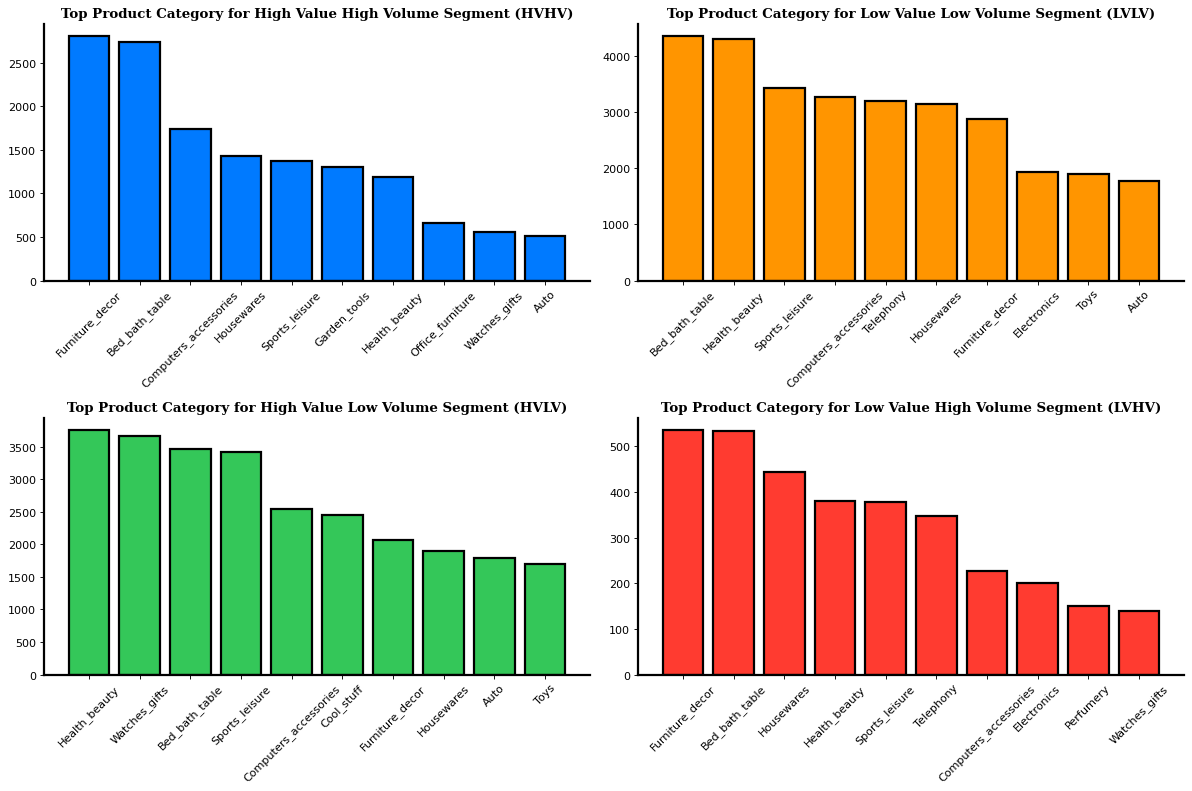

In [34]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot 1 : Top Product category for HVHV (High Value High Volume)
x = hvhv_values.index[:10]
y = hvhv_values.values[:10]
ax1.bar(x, y, linewidth=2, edgecolor='black',color=[light_palette[0]] * 10)
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x.map(lambda val: val.capitalize()), rotation = 45)
ax1.set_title("Top Product Category for High Value High Volume Segment (HVHV)", fontsize=12, fontweight='bold', fontfamily='serif')

# Plot 2 : Top Product category for LVLV (Low Value Low Volume)
x = lvlv_values.index[:10]
y = lvlv_values.values[:10]
ax2.bar(x, y, linewidth=2, edgecolor='black',color=[light_palette[1]] * 10)
ax2.set_xticks(range(len(x)))
ax2.set_xticklabels(x.map(lambda val: val.capitalize()), rotation = 45)
ax2.set_title("Top Product Category for Low Value Low Volume Segment (LVLV)", fontsize=12, fontweight='bold', fontfamily='serif')

# Plot 3 : Top Product category for HVLV (High Value Low Volume)
x = hvlv_values.index[:10]
y = hvlv_values.values[:10]
ax3.bar(x, y, linewidth=2, edgecolor='black',color=[light_palette[2]] * 10)
ax3.set_xticks(range(len(x)))
ax3.set_xticklabels(x.map(lambda val: val.capitalize()), rotation = 45)
ax3.set_title("Top Product Category for High Value Low Volume Segment (HVLV)", fontsize=12, fontweight='bold', fontfamily='serif')

# Plot 4 : Top Product category for LVHV (Low Value High Volume)
x = lvhv_values.index[:10]
y = lvhv_values.values[:10]
ax4.bar(x, y, linewidth=2, edgecolor='black',color=[light_palette[3]] * 10)
ax4.set_xticks(range(len(x)))
ax4.set_xticklabels(x.map(lambda val: val.capitalize()), rotation = 45)
ax4.set_title("Top Product Category for Low Value High Volume Segment (LVHV)", fontsize=12, fontweight='bold', fontfamily='serif')

# === Axis ===
# Spine
for ax in [ax1,ax2,ax3,ax4]:
  for s in ['top',  'right']:
      ax.spines[s].set_visible(False)
  # Linewidth
  ax.spines['bottom'].set_linewidth(2)
  ax.spines['left'].set_linewidth(2)


plt.tight_layout()
plt.savefig("../reports/visualization/rfm-trend4.png")
plt.show()

---

<font size=-1><i>
From plot above, we can see top product category for each customer segment. While some of the product category occurs in all customer segment, like Furniture & Decoration and Bed Bath and Table, most of the other product category are not same. Thus, we might be able to achieve more accurate recommendation if we recommend different product category for different customer segment  

</i></font>

---

<font color="slategray" size=+0.5><b>Insight</b></font>

<font size=-1>
<i>
As final takeaway, here are the things that we need to look out for : 
<ul>
  <font size=-1>
  <li>The average for new user growth each month for our ecommerce is about 68.3%, while the average for returning user growth each month for our ecommerce is about 41.53% (early - mid 2016 & late 2018)</li>
  <li>As a side note too, the new user and returning user of our ecommerce is steadily increasing, while the growth is steadily decreasing to normal ecommerce rate</li>
  <li>From early - mid 2016 & late 2018, the ecommerce have about 1:28 ratio of returning user vs new user. It means that for every 28 new user, one of the would be our loyal customer </li>
  <li>Most user (around 92k) only purchase 1 times from the ecommerce. Meanwhile, there are about (~ 3k) user that purchase more than 1 times.</li>
  <li>Majority of customers who repurchase order leave between 22 and 168 days to do so. The upper quartile (Q3) suggests that there is a rough interval of 183 days which sits about 6 months, which can be used as cutoff interval for recent purchases.
  </li>
  <li>Based on our simple order behaviour customer segmentation, we can see that most of our customers are low value and low volume, then followed by customers with a high value but low volume</li>
  </font>
</ul>
</i></font>

<font color="slategray" size=+0.5><b>Recommendation</b></font>

<font size=-1><i>
Based on insight that we get from the analysis above, we can recommend few things:
<ul>
  <font size=-1>
  <li>Use customer retention strategies to prevent customer lost. We have about ~17k inactive user that were important customer.Offer personalized discount voucher, personal email marketing to engage with them.</li>
  <li>Give reward for our loyal customer. We have about ~40k active user that might be potential loyalist customer.Offer marketing loyalty program, recommend other products, make a higher quit gate.</li>
  <li>Create more personalized recommendation for each customer segment. With more accurate recommendation, we can create a good user experience and increase in sales</li>
  <font>
</ul>
</i></font>

## <font color="black" size=+1.5><b>3.4 Location Logistic Analysis</b></font>

<font color="slategray" size=+0.5><b>Purpose</b></font>

<font size=-1><i>
  <ul>
    <li>Where is the <b>customer and seller located</b>? What about the <b>distribution</b> of their location?</li>
    <li>What about the <b>frequency of purchase</b> on each state?</li>
    <li>Which <b>logistic route</b> that have <b>heavy traffic</b> in our ecommerce?</li>
  </ul>
</i></font>



<font color="slategray" size=+0.5><b>Background</b></font>

<font size=-1><i>
Location is one of the most important aspect when formulating a business decision. Running an ecommerce doesn't mean that location don't matter anymore. Where we live, the environment, and local custom still affect the what customer usually buy including online commerce.
<br>
One of the easiest way to understand the characteristic of customer in specific location is by analyzing our existing customer as it can be one of the most useful source of information for our next new customer.
<br>
Not only that, one of the strategy in ecommerce called <b>geotargeting</b> only can be done after we understand user demographic. Because geotargeting is often used in combination with other kinds of targeting, using other kinds of demographic data or even psychographic data we can understand more on <b>buyer motivation and prevent us to target customer demographic that most likely not going to use our service</b>.
<br>
The difference location between customer & seller might also hinder the logistic process. By understanding the geolocation of our ecommerce user, we can make better business decision like improving facilities to the states that have a good growth or improving ads quality to focus on lowering new customer gate for low growth states.
<br>

</i></font>

<font color="slategray" size=+0.5><b>In General & Assumption</b></font>

<font size=-1><i>
Based on my assumption, I think that most of the user & seller would be from Pulau Jawa (especially Jawa Barat & DKI Jakarta), because the technology there have really surpass many states. For the purchase frequency itself, I feel like most likely Pulau Jawa will also be the most crowded.
</i></font>

In [35]:
# Init needed data

QUERY_USER = """
select * 
from staging.dim_user;
"""

QUERY_SELLER = """
select * 
from staging.dim_seller;
"""

QUERY_ORDER = """
select 
	distinct 
	foi.order_id ,
	df.feedback_score ,
  -- user attr
	du.user_name ,
	du.customer_geo_id ,
  -- seller attr
  ds.seller_geo_id,
  -- order details attr
  dd.month_actual as order_month,
  dd.year as order_year,
  dd.date as order_date

from staging.fct_order_items foi 
left join staging.dim_feedback df on foi.feedback_key = df.feedback_key 
left join staging.dim_date dd on foi.order_date = dd.date_id 
left join staging.dim_user du on foi.user_key = du.user_key
left join staging.dim_seller ds on foi.seller_key = ds.seller_key;
"""

QUERY_STATE = """
select 
  state,
  AVG(lat) as lat,
  AVG(long) as long
from staging.dim_geo
group by 1;
"""

# Init dataframe
user_df = pd.read_sql_query(QUERY_USER, conn)
seller_df = pd.read_sql_query(QUERY_SELLER, conn)
order_df = pd.read_sql_query(QUERY_ORDER, conn)

state_geo = pd.read_sql_query(QUERY_STATE, conn)

df_geo_cust = df_geo.copy()
df_geo_cust.columns = ['customer_geo_id', 'customer_city', 'customer_state', 'customer_long', 'customer_lat']

df_geo_seller = df_geo.copy()
df_geo_seller.columns = ['seller_geo_id', 'seller_city', 'seller_state', 'seller_long', 'seller_lat']

order_df['order_year_month'] = order_df['order_date'].apply(lambda x: x.strftime('%Y%m'))
user_geo = df_geo.merge(user_df, how="inner", left_on="geo_id", right_on="customer_geo_id")
seller_geo = df_geo.merge(seller_df, how="inner", left_on="geo_id", right_on="seller_geo_id")
order_df_temp = df_geo_cust.merge(order_df, how="inner", left_on="customer_geo_id", right_on="customer_geo_id")
order_geo = df_geo_seller.merge(order_df_temp, how="inner", left_on="seller_geo_id", right_on="seller_geo_id")


<font size=-1><i>
<pre>
Where is the <b>customer and seller located</b>? What about the <b>distribution</b> of their location?
</pre>
To answer that question, I will try to give a interactive map dashboard to view number of user & seller on specific state. This dashboard will use information provided by user (most likely from order delivery location) & seller (registrated location)
</i>
</font>

***

*User vs Seller Location Distribution*

In [36]:
values = user_geo.state.value_counts()

fig = go.Figure(go.Treemap(
    labels = values.index,
    parents = ['Indonesia'] * len(values),
    values = values
))

fig.update_layout(title = 'User Location')
fig.show()

# py.plot(fig, filename="user_location_treemap", auto_open = True)

In [37]:
values = seller_geo.state.value_counts()

fig = go.Figure(go.Treemap(
    labels = values.index,
    parents = ['Indonesia'] * len(values),
    values = values,
    
))

fig.update_layout(title = 'Seller Location')
fig.show()

# py.plot(fig, filename="seller_location_treemap", auto_open = True)

In [38]:
# Zipping locations
user_lats = list(user_geo['lat'].dropna().values)
user_longs = list(user_geo['long'].dropna().values)
user_locations = list(zip(user_lats, user_longs))

seller_lats = list(seller_geo['lat'].dropna().values)
seller_longs = list(seller_geo['long'].dropna().values)
seller_locations = list(zip(seller_lats, seller_longs))

# Adding Html
loc = 'User vs Seller Location'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

# Creating a mapa using folium
map = DualMap(location=[-6.3, 115.816666], tiles="cartodbpositron", zoom_start=5.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=user_locations).add_to(map.m1)
FastMarkerCluster(data=seller_locations).add_to(map.m2)

# Minimap
minimap = MiniMap(toggle_display=True, tile_layer="Stamen Toner")
minimap.add_to(map.m2)
map
# map.save("../reports/user-seller.html")

---

<font size=-1><i>
From what we can see in user map the number of user is mostly concentrated in <b>Pulau Jawa</b> (with the most concentration in Jawa Barat & DKI Jakarta), followed by <b>Pulau Sumatera</b> (distributed quite well, but still heavily concentrated in Sumatera Utara)
<br>
Meanwhile from the seller map itself, we can see that nearly all our seller is from <b>Jawa Barat, DKI Jakarta and Bandung</b>.
<br>
</i></font>

---


<font size=-1><i>
<pre>
What about the <b>frequency of purchase</b> on each state?
</pre>
To answer that question, I will try to make a interactive map dashboard to indicate the intensity of purchase frequency, so we can pinpoint what state have most order traffic for our ecommerce
</i>
</font>

***

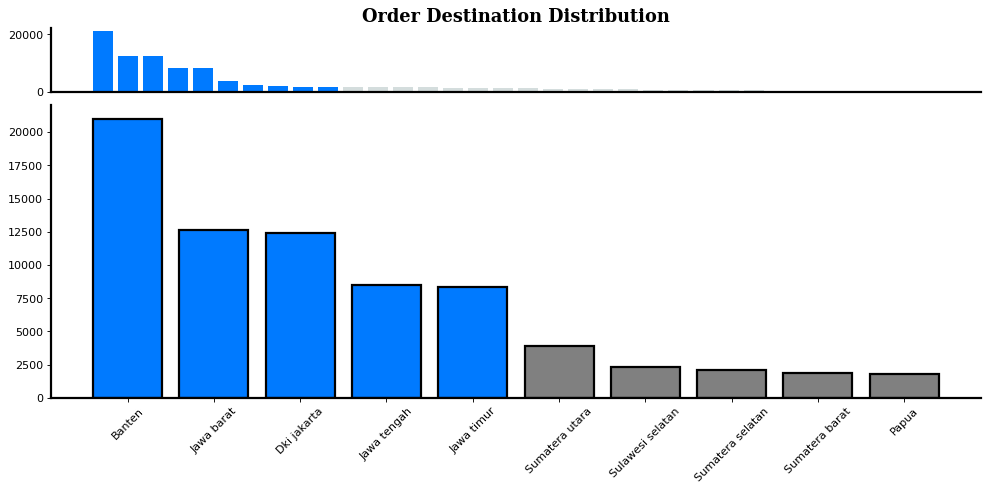

In [39]:
fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(5, 6)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

# Prepare
no_duplicate_customer_order_geo = order_geo.drop_duplicates(['order_id', 'user_name'])
values = no_duplicate_customer_order_geo.customer_state.value_counts()
# === All plot ===
x = values.index
y = values.values
ax1.bar(x, y,
       color=[light_palette[0]]*10 + ['#d4dddd']*(len(x) - 10)
       )
ax1.set_xticks([])
ax1.set_title("Order Destination Distribution", fontsize=16, fontweight='bold', fontfamily='serif')

# === Specific ===
x_specify = x[:10]
y_specify = y[:10]
ax2.bar(x_specify, y_specify, linewidth=2, edgecolor='black',color=[light_palette[0]] * 5 + ['gray'] * 5)
ax2.set_xticks(range(len(x_specify)))
ax2.set_xticklabels(x_specify.map(lambda val: val.capitalize()), rotation = 45)

# Spine
for s in ['top',  'right']:
    ax2.spines[s].set_visible(False)

# Linewidth
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

# fig.text(0.125,0.9,'Order Destination Distribution', fontsize=20, fontweight='bold', fontfamily='serif')
plt.savefig("../reports/visualization/geo-trend1.png")
plt.show()

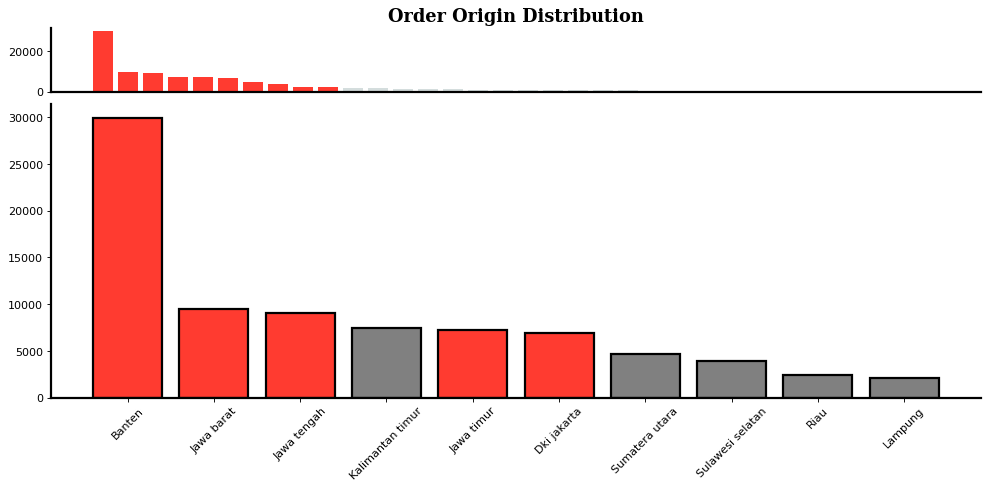

In [40]:
fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(5, 6)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

# Prepare
no_duplicate_customer_order_geo = order_geo.drop_duplicates(['order_id', 'user_name'])
values = no_duplicate_customer_order_geo.seller_state.value_counts()
# === All plot ===
x = values.index
y = values.values
ax1.bar(x, y,
       color=[light_palette[3]]*10 + ['#d4dddd']*(len(x) - 10)
       )
ax1.set_xticks([])
ax1.set_title("Order Origin Distribution", fontsize=16, fontweight='bold', fontfamily='serif')

# === Specific ===
x_specify = x[:10]
y_specify = y[:10]
ax2.bar(x_specify, y_specify, linewidth=2, edgecolor='black', color=[light_palette[3]] * 3 + ['gray'] + [light_palette[3]] * 2 + ['gray'] * 4)
ax2.set_xticks(range(len(x_specify)))
ax2.set_xticklabels(x_specify.map(lambda val: val.capitalize()), rotation = 45)

# Linewidth
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

plt.savefig("../reports/visualization/geo-trend2.png")
plt.show()

***
<font size=-1><i>

From order destination, we can see that the top 5 destination states located in Pulau Jawa.
<br>
Meanwhile order origin, we can see that most of the order origin states (where seller are located) are in Pulau Jawa. But surprisingly about 8.7 % from our seller located in Kalimantan Timur. This fact alone further prove our hypothesis that most likely order happen between seller & customer from Pulau Jawa.
<br>
</i>
</font>

***

***
<font size=-1><i>
To understand more about our ecommerce order traffic between city, I create a map that shows the logistic route path for analyzing order that have different states.

To make it easier for our eyes to infer the data, I seperate the different states order into 10 parts (using quantile), so that we can see which logistic path is heavily used and which is slightly used.
</i>
</font>

***

In [41]:
# Reduce the complexity
import collections

order_route_grouped_geo = order_geo.groupby(['customer_state', 'seller_state']).agg(
    count=('order_id', 'size'),
  ).reset_index()

state_geo_cust = state_geo.copy()
state_geo_cust.columns = ['customer_state', 'customer_lat', 'customer_long']

state_geo_seller = state_geo.copy()
state_geo_seller.columns = ['seller_state', 'seller_lat', 'seller_long']

order_route_temp = state_geo_seller.merge(order_route_grouped_geo, how="inner", left_on="seller_state", right_on="seller_state")
order_route_grouped_geo = state_geo_cust.merge(order_route_temp, how="inner", left_on="customer_state", right_on="customer_state")
order_route_grouped_geo = order_route_grouped_geo[['seller_state','customer_state','seller_lat', 'seller_long', 'customer_lat', 'customer_long', 'count']]
order_route_grouped_geo.columns = ['start_state', 'end_state', 'start_lat', 'start_long', 'end_lat', 'end_long', 'count']
order_route_grouped_geo['quantile_order_size'] = pd.qcut(order_route_grouped_geo['count'], q=10, duplicates='drop', labels= False)

colors = raw_light_palette
color_map = {}

quantile_coordinates = {}

for quantile in order_route_grouped_geo.quantile_order_size.unique():
  start_coordinates = order_route_grouped_geo.loc[order_route_grouped_geo.quantile_order_size == quantile][['start_lat', 'start_long', 'start_state']].values.tolist()
  end_coordinates = order_route_grouped_geo.loc[order_route_grouped_geo.quantile_order_size == quantile][['end_lat', 'end_long', 'end_state']].values.tolist()
  # Process here
  coordinates = []
  for start, end in zip(start_coordinates, end_coordinates):
    if (start[-1] != end[-1]):
      coordinates.append([start[:-1],end[:-1],[start[-1], end[-1]]])
  
  quantile_coordinates[quantile] = coordinates

colors = [
  ["#F08FC0", "#FBC7F7", "#F7DBF0"], # pink pallete
  ['#aa2ee6', '#c67ace', '#ff79cd'], # violet pallete
  ["#DA0037", "#D83A56", "#F55C47"], # red pallete
  ['#ff6701', '#fea82f', '#ffc288'], # orange pallete
  ["#FFC947", "#FFED99", "#FFFFC7"], # yellow pallete
  ["#39A6A3", "#7DEDFF", "#00EAD3"], # teal pallete
  ['#52734d', '#91c788', '#ddffbc'], # green pallete
  ["#96BAFF", "#78DEC7", "#CDF0EA"], # indigo pallete
  ['#77acf1', '#3edbf0', '#c0fefc'], # blue pallete
  ["#171010", "#2B2B2B", "#343A40"], # Black pallete
]
colors_map = {}
for idx, key in enumerate(sorted(order_route_grouped_geo.quantile_order_size.unique(), reverse=False)):
  colors_map[key] = colors[idx]

map = folium.Map(
    location=[-6.3, 115.816666], zoom_start=5.0, tiles="cartodbpositron"
)

quantile_coordinates = collections.OrderedDict(sorted(quantile_coordinates.items()))

for key, value in quantile_coordinates.items():
  fg = folium.FeatureGroup(name=f"Freq Q-{key + 1}")
  for loc in value:
    # add starting location markers to the map
    folium.CircleMarker(location=(loc[0][0], loc[0][1]),color=colors_map[key][0],radius=5,weight=1,fill=True, tooltip=f"{loc[-1][0]}").add_to(fg)

    # add starting location markers to the map
    folium.CircleMarker(location=(loc[1][0], loc[1][1]),color=colors_map[key][2],radius=5,weight=1,fill=True, tooltip=f"{loc[-1][1]}").add_to(fg)

    folium.PolyLine(loc[:-1], weight=.5,color=colors_map[key][1], tooltip=f"{loc[-1][0]} - {loc[-1][1]} | Q{key + 1}").add_to(fg)

  map.add_child(fg)

folium.LayerControl().add_to(map)
map
# map.save("../reports/order-traffic.html")

***
<font size=-1><i>
By using above route plotting, we can see the categorization of logistic based on order frequency (with Q1 is the lowest frequency while Q5 is the highest frequency). In Q5 category, we can see that most of the time, the item is either from states in Pulau Jawa (especially Jawa Barat & DKI Jakarta) to other states. Q4 is similar with Q5 routes, with some of states in Pulau Sumatera and Sulawesi also indicating that there are many transaction using from this route.
<br>
When trying to improve the time needed to transport the item to user when ordering / purchasing, starting by focusing on the most traffic routes might be a good ways to improve the estimation and time needed to deliver the product..
</i>
</font>

***

<font color="slategray" size=+0.5><b>Insight</b></font>

<font size=-1>
<i>
As final takeaway, here are the things that we need to look out for : 
<ul>
  <font size=-1>
  <li>The distribution of user is mostly concentrated in <b>Pulau Jawa</b> (with the most concentration in Jawa Barat & DKI Jakarta), followed by <b>Pulau Sumatera</b> (distributed quite well, but still heavily concentrated in Sumatera Utara)</li>
  <li>Meanwhile nearly all our seller is from <b>Jawa Barat, DKI Jakarta and Bandung</b></li>
  <li>Same as the distribution for user, most of the time order is delivered to user located in Pulau Jawa, especially big states like DKI Jakarta, Bandung, Jawa Barat, Jawa Tengah and Surabaya </li>
  </font>
</ul>
</i></font>

<font color="slategray" size=+0.5><b>Recommendation</b></font>

<font size=-1><i>
Based on insight that we get from the geolocation analysis, we can recommend few things:
<ul>
  <font size=-1>
  <li>Most of the time, order from different states are either from seller in Pulau Jawa (especially Jawa Barat & DKI Jakarta), Pulau Sumatera (especially Sumatera Utara) to other states. If we want to improve the speed and quality for shipping process, focusing on this common route might be a good thing.</li>
  <li>When looking to expand our ecommerce, we have 2 option. First, we can try to just focusing on Pulau Jawa, because all of our transaction happen here. Increasing the delivery time, customer service on specific area might increase the popularity of our ecommerce instantly in Pulau Jawa. Second, we also can try to expand to Pulau Kalimantan and Pulau Sumatera. Both of this area have quite promising prospect and focusing those area might create new customer-seller cluster similar to Pulau Jawa (which is a good thing!!)</li>
  <font>
</ul>
</i></font>

## <font color="black" size=+1.5><b>3.5 Delivering Process Analysis</b></font>

<font color="slategray" size=+0.5><b>Purpose</b></font>

<font size=-1><i>
  <ul>
    <li>How many <b>late delivered order</b> in our ecommerce? Are <b>late order affecting the customer satisfaction</b>?</li>
    <li>How long are the <b>delay for delivery / shipping process</b> in each state? </li>
    <li>How long are the <b>difference between estimated delivery time and actual delivery time</b> in each state? </li>
  </ul>
</i></font>

<font color="slategray" size=+0.5><b>Background</b></font>

<font size=-1>
<i>
Big ecommerce company like Amazon, eBay, Alibaba, etc have changed the way we shop. US eCommerce sales alone increased by over $50 billion from 2015 to 2016 and continues to grow today. eCommerce now accounts for over 10% of all retail sales. But the increasing popularity of online shopping comes with pitfalls. Many of new ecommerce just cannot compete with existing competition. 
So how can we as a new and upcoming ecommerce compete with existing popular ecommerce. 
<br>
<br>
One way to compete is by <b>optimizing every touchpoint in our ecommerce business process</b> to <b>increase customer satisfaction</b> when using our ecommerce. Every single thing your customer experiences related to your brand, from how fast your page loads on your store to the branded shipping label and packing tape on your package is an opportunity to make your brand their favorite. Think like your customer and imagine every contact and situation you could possibly have with them from the beginning of their transaction to the end. Then find ways to make each of them the best they can be. Customer are very demanding and spoiled because the big online retailers have raised the bar impossibly high for many smaller sellers. 
<br>
<br>
Thus there are many <b>challenge to increase the customer satisfaction</b>, such as market evolution, increasing customer fulfilment by other competitor ecommerce, faster delivery expectation, etc. In this analysis, I want to emphasis <b>faster delivery expectation</b> challenge so we can see the effect of <b>delivery process on our ecommerce customer satisfaction.</b>
</i></font>

<font color="slategray" size=+0.5><b>In General & Assumption</b></font>

<font size=-1><i>
For this analysis, I will only use order data that had been <b>delivered or cancelled</b>, which means I won't include data from order with status : <b>unavailable, invoiced, approved, processing.</b> Also, I will only use order data that only include single customer - seller relation (not multiple seller in 1 order)   
</i></font>

In [42]:
ORDER_QUERY = """
select 
	distinct 
	-- identifier attr
	foi.order_id,
	du.user_name ,
	MAX(ds.seller_id) as seller_id,

  AVG(df.feedback_score) as feedback_score,
	
  SUM(foi.shipping_cost) as shipping_cost,
  SUM(foi.price) as total_price,
  MAX(foi.order_item_status) as order_status,
	
	-- origin (seller) location
	MAX(dgs.city) as seller_city,
  MAX(dgs.state) as seller_state,
  
	-- destination (customer) location
	MAX(dgc.city) as customer_city,
  MAX(dgc.state) as customer_state,

  -- order attr
  MAX(dd.date) as order_date,
  case when MIN(dd."isWeekend"::int) = 1 then true else false end as order_is_weekend ,
  
  MAX(dt.hour) as order_hour,
  MAX(dt.daytime) as order_daytime,
  	
  -- approved details attr
  MAX(dda.date) as order_approved_date,
  case when MIN(dda."isWeekend"::int) = 1 then true else false end as order_approved_is_weekend ,
  
  MAX(dta.hour) as order_approved_hour,
  MAX(dta.daytime) as order_approved_daytime,
  	
  -- pickup limit date
  MAX(ddp.date) as pickup_limit_date,
  case when MIN(ddp."isWeekend"::int) = 1 then true else false end as pickup_limit_is_weekend ,	
	
  -- estimated delivery date
	MAX(dde.date) as estimated_date_delivery,

	-- target
	MAX(ddd.date) as actual_date_delivery
	
from staging.fct_order_items foi
left join staging.dim_date dd on foi.order_date = dd.date_id 
left join staging.dim_time dt on foi.order_time = dt.time_id 
left join staging.dim_date dda on foi.order_approved_date = dda.date_id
left join staging.dim_time dta on foi.order_approved_time = dta.time_id 
left join staging.dim_date ddp on foi.pickup_limit_date = ddp.date_id 
left join staging.dim_date dde on foi.estimated_date_delivery = dde.date_id 
left join staging.dim_date ddd on foi.delivered_date = ddd.date_id  
left join staging.dim_user du on foi.user_key = du.user_key
left join staging.dim_seller ds on foi.seller_key = ds.seller_key
left join staging.dim_geo dgs on  ds.seller_geo_id = dgs.geo_id 
left join staging.dim_geo dgc on du.customer_geo_id = dgc.geo_id 
left join staging.dim_feedback df on df.feedback_key = foi.feedback_key 
where foi.order_item_status in ('delivered', 'cancelled')
group by 1,2
having count(distinct foi.seller_key) <= 1
"""

PRODUCT_QUERY = """
select 
	foi.order_id,
	dp.product_category ,
	count(foi.order_item_id) as total_item_per_category,
	
	-- estimated delivery date
	MAX(dde.date) as estimated_date_delivery,

	-- target
	MAX(ddd.date) as actual_date_delivery
	
from staging.fct_order_items foi
left join staging.dim_product dp on dp.product_key = foi.product_key 
left join staging.dim_date dde on foi.estimated_date_delivery = dde.date_id 
left join staging.dim_date ddd on foi.delivered_date = ddd.date_id  
where foi.order_item_status in ('delivered', 'cancelled')
group by 1,2
having count(distinct foi.seller_key) <= 1
"""

order_df = pd.read_sql_query(ORDER_QUERY, conn)
product_df = pd.read_sql_query(PRODUCT_QUERY, conn)

In [43]:
# Base Transformer
class Transformer(object):
    def __init__(self, df, transformation_map):
        self.df = df.copy()
        self.transformation_map = transformation_map 
  
    def parse(self):
        pass 

    def clean(self):
        pass

    def transform(self):
        if self.transformation_map is not None : 
            df = self.df.copy()
            for key, value in tqdm(self.transformation_map.items()):
                df[key] = df.apply(
                    value,
                    axis = 1
                )
            self.df = df
        else :
            raise Exception("Null Transformation Map")

    def get_data(self):
        return self.df

    def process(self):
        self.parse()
        self.clean()
        self.transform()
        return self.get_data()

class OrderDateTransformer(Transformer):
    def __init__(self, df):
        transformation = {
            # Check Delta interval from order -> arrive to customer
            'wd_actual_delivery_interval' : lambda row: (row.actual_date_delivery - row.order_date).days,

            # Calculate the difference between estimated and actual delivery interval
            'wd_actual_estimated_interval' : lambda row: (row.actual_date_delivery - row.estimated_date_delivery).days,

            # Check if product delivery is late
            'is_late' : lambda row: (row.estimated_date_delivery - row.actual_date_delivery).days < 0,
        }
        
        super().__init__(df, transformation)

    def parse(self):
        df = self.df.copy()
        df['order_date'] = pd.to_datetime(df['order_date'], format='%Y-%m-%d')
        df['order_approved_date'] = pd.to_datetime(df['order_approved_date'], format='%Y-%m-%d')
        df['actual_date_delivery'] = pd.to_datetime(df['actual_date_delivery'], format='%Y-%m-%d')
        df['estimated_date_delivery'] = pd.to_datetime(df['estimated_date_delivery'], format='%Y-%m-%d')
        df['pickup_limit_date'] = pd.to_datetime(df['pickup_limit_date'], format='%Y-%m-%d')
        self.df = df 

    def clean(self):
        # Drop misuse col
        df = self.df.copy()

        # Remove all record that have missed information in it
        df = df.dropna(subset=['order_approved_date', 'actual_date_delivery'])

        # Remove all record that delivered before approved (misuse of the ecommerce system)
        df = df.loc[~(df.actual_date_delivery < df.order_approved_date)]
        df = df.loc[~(df.estimated_date_delivery < df.order_approved_date)]

        # Copy back again data into original data
        self.df = df 

class ProductDateTransformer(Transformer):
    def __init__(self, df):
        transformation = {
            # Check if product delivery is late
            'is_late' : lambda row: (row.estimated_date_delivery - row.actual_date_delivery).days < 0,
        }
        super().__init__(df, transformation)

    def parse(self):
        df = self.df.copy()
        df['actual_date_delivery'] = pd.to_datetime(df['actual_date_delivery'], format='%Y-%m-%d')
        df['estimated_date_delivery'] = pd.to_datetime(df['estimated_date_delivery'], format='%Y-%m-%d')
        self.df = df 

order_date_transformer = OrderDateTransformer(order_df)
order_df = order_date_transformer.process()

product_date_transformer = ProductDateTransformer(product_df)
product_df = product_date_transformer.process()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


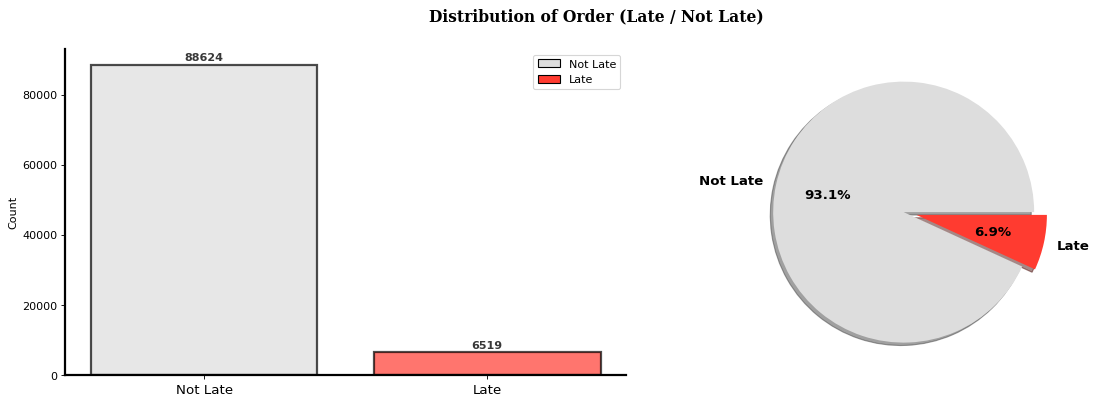

In [44]:
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
# Axis definition
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

color = ['#dddddd', mpl.colors.to_hex(light_palette[3])]

# === Countplot ===
label = ['Not Late', 'Late']
x = order_df.is_late.value_counts().sort_index().index
y = order_df.is_late.value_counts().sort_index().values
ax1.bar(x, y, color=color, edgecolor='black', alpha=0.7, linewidth=2)
ax1.set_xticks(list(x))
ax1.set_xticklabels(label, fontsize=12)
ax1.set_ylabel("Count")
# Spine
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)

legend_elements = [
  Patch(facecolor=color[0], edgecolor='black', label='Not Late'), 
  Patch(facecolor=color[1], edgecolor='black', label='Late')
]
ax1.legend(handles=legend_elements,loc='upper right', ncol=1)

# Annotate
for idx, item in enumerate(x):
    ax1.annotate(f"{y[idx]}", 
                   xy=(item, y[idx] + 2000),
                   va = 'center', ha='center',fontweight='bold', color='#383838'
                  )

# Spine
for s in ['top',  'right']:
    ax1.spines[s].set_visible(False)

explode = [0, 0.1]
values = order_df.is_late.value_counts()
ax2.pie(values,
            labels=["Not Late", "Late"],
            colors=color, # color
            explode=explode, # explode
            textprops={'fontsize': 12, 'fontweight': 'bold'}, # text setting
            autopct='%1.1f%%', # notation
            shadow=True # shadow
           )

fig.suptitle(f'Distribution of Order (Late / Not Late)', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')


plt.tight_layout()
plt.savefig("../reports/visualization/delivery-trend1.png")
plt.show()


<font size=-1><i>
From plot above, we can see that most of the time the order is delivered on time. But still, there are about ~6.9% that order were delivered late.
<pre>
Are late delivered order affecting our customer satisfaction?
</pre>
</i>
</font>

***

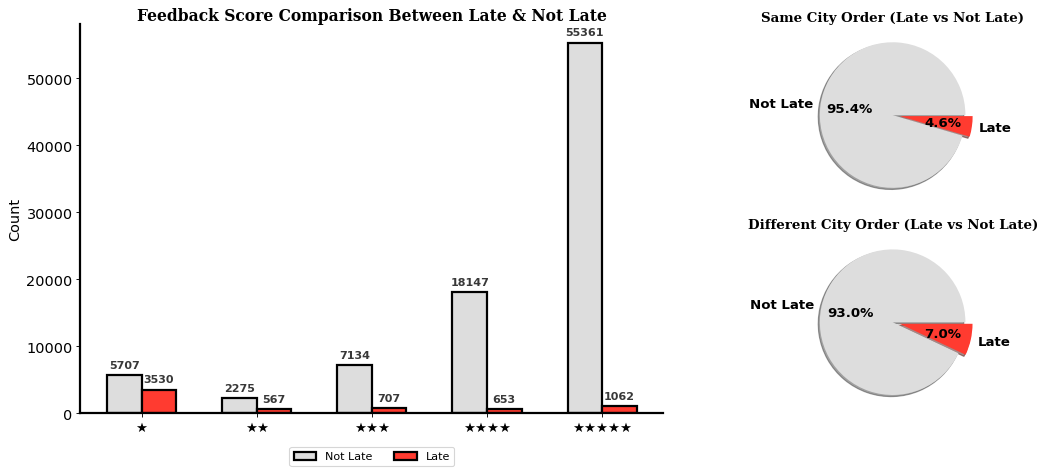

In [45]:
fig = plt.figure(figsize=(15, 6), constrained_layout=True)
# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

color = ['#dddddd', mpl.colors.to_hex(light_palette[3])]

# === Review score grouped 
score_label = ['★', '★★', '★★★', '★★★★', '★★★★★',]
x = np.arange(len(score_label)) 
y1 = order_df.loc[~order_df.is_late].feedback_score.value_counts().sort_index().values
y2 = order_df.loc[order_df.is_late].feedback_score.value_counts().sort_index().values
width=0.3

# First Bar Plot
ax1.bar(x-width/2, y1, 
       color=color[0],
       edgecolor='black',
       linewidth=2,
       width=width,
       label='Not Late'
      )
# Second Bar Plot
ax1.bar(x+width/2, y2, 
       color=color[1],
       edgecolor='black',
       linewidth=2,
       width=width,
       label='Late'
      )

# Annotate
for idx, item in enumerate(x):
  # Percentage
  ax1.annotate(f"{y1[idx]}", 
                  xy=(item-width/2, y1[idx] + 1500),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )
  ax1.annotate(f"{y2[idx]}", 
                  xy=(item+width/2, y2[idx] + 1500),
                  va = 'center', ha='center',fontweight='bold', color='#383838'
                )

# Spine
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)

# Legend & Ticks
ax1.set_title('Feedback Score Comparison Between Late & Not Late', loc='center', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
ax1.set_ylabel("Count", fontsize=13, fontweight='medium')
ax3.set_ylim(0,55000)
ax1.set_xticks(x)
ax1.set_xticklabels(score_label, fontsize=12)
ax1.tick_params(axis='y', which='major', labelsize=13)
ax1.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

# === Plot 4 : Is late x same area ===
order_df['is_same_city'] = order_df.customer_city == order_df.seller_city
explode = [0, 0.1]
values = order_df.loc[order_df.is_same_city].is_late.value_counts()
ax2.pie(values,
            labels=["Not Late", "Late"],
            colors=color, # color
            explode=explode, # explode
            textprops={'fontsize': 12, 'fontweight': 'bold'}, # text setting
            autopct='%1.1f%%', # notation
            shadow=True # shadow
           )
ax2.set_title('Same City Order (Late vs Not Late)', loc='center', fontsize=12, va= 'center', fontfamily='serif',fontweight='semibold')

values = order_df.loc[~order_df.is_same_city].is_late.value_counts()
ax3.pie(values,
            labels=["Not Late", "Late"],
            colors=color, # color
            explode=explode, # explode
            textprops={'fontsize': 12, 'fontweight': 'bold'}, # text setting
            autopct='%1.1f%%', # notation
            shadow=True # shadow
           )
ax3.set_title('Different City Order (Late vs Not Late)', loc='center', fontsize=12, va= 'center', fontfamily='serif',fontweight='semibold')



plt.tight_layout()
plt.savefig("../reports/visualization/delivery-trend2.png")
plt.show()

***
<font size=-1><i>
We can see that the ratio of not late vs late order are slightly decreasing for each increasing customer review score. It means that late order are more likely to get bad feedback than on-time order. 
<br>
From the pie chart, we can see that order with different city (between customer and seller) have slightly higher late rate than in same city. This might be because the shipping process for different city are not as good as the same city.
</i>
</font>

***

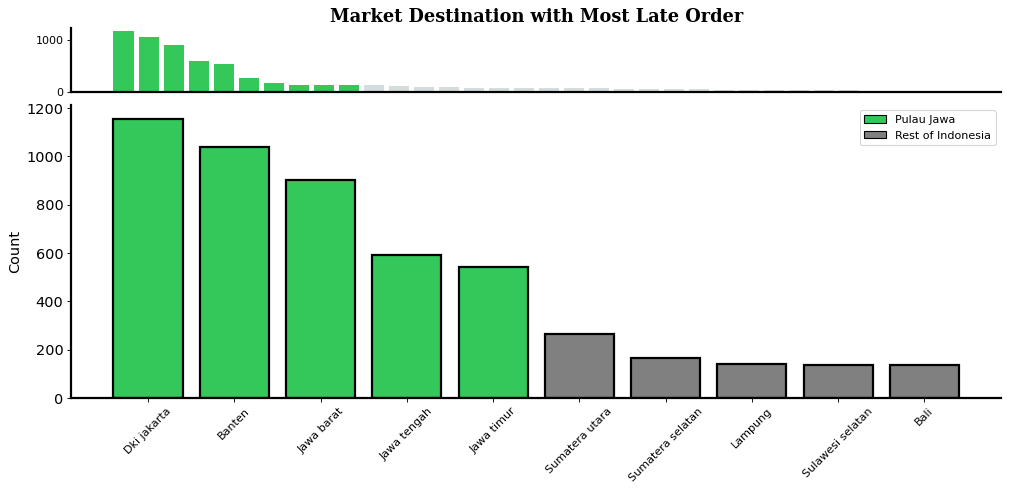

In [46]:
fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(5, 6)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

# Prepare
values = order_df.loc[order_df.is_late].customer_state.value_counts()

# === All plot ===
x = values.index
y = values.values
ax1.bar(x, y,
       color=[light_palette[2]]*10 + ['#d4dddd']*(len(x) - 10)
       )
ax1.set_xticks([])
ax1.set_title("Market Destination with Most Late Order", fontsize=16, fontweight='bold', fontfamily='serif')
# Spine
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)

# === Specific ===
x_specify = x[:10]
y_specify = y[:10]
ax2.bar(x_specify, y_specify, edgecolor='black', linewidth=2, color=[light_palette[2]] * 5 + ['gray'] * 5)
ax2.set_xticks(range(len(x_specify)))
ax2.set_xticklabels(x_specify.map(lambda val: val.capitalize()), rotation = 45)

# Spine
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

legend_elements = [
  Patch(facecolor=light_palette[2], edgecolor="black", label='Pulau Jawa'), 
  Patch(facecolor='gray', edgecolor='black', label='Rest of Indonesia')
]
ax2.legend(handles=legend_elements,loc='upper right', ncol=1)

ax2.set_ylabel("Count", fontsize=13, fontweight='medium')
ax2.tick_params(axis='y', which='major', labelsize=13)

plt.savefig("../reports/visualization/delivery-trend3.png")
plt.show()

***
<font size=-1><i>
When we try to analyse which states with most late order, we can see that states in Pulau Jawa is the destination where late order most likely to occur. This seems reasonable though, because Pulau Jawa is the heaviest traffic states in Indonesia for our ecommerce sales
</i>
</font>
***

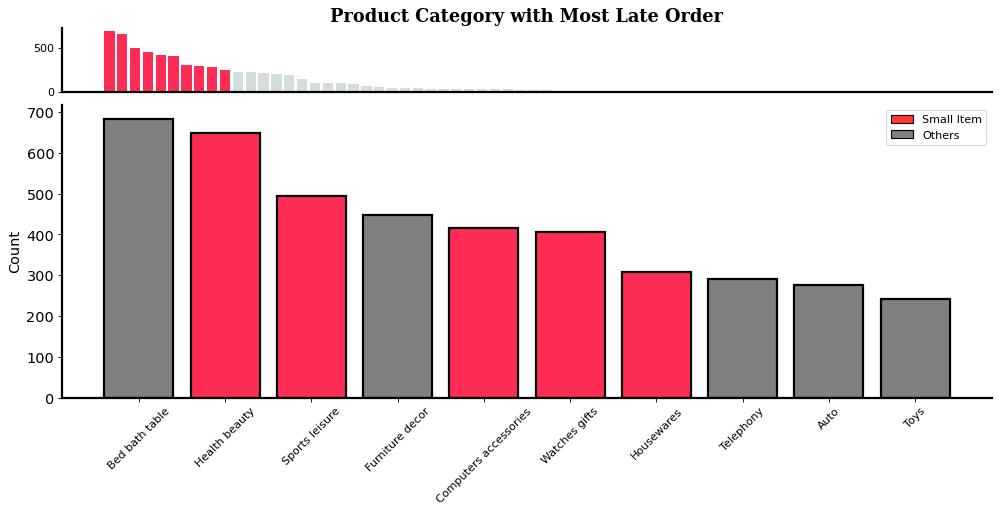

In [47]:
fig = plt.figure(figsize=(15, 6))
gs = fig.add_gridspec(5, 6)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1:,:])

# Prepare
values = product_df.loc[product_df.is_late].product_category.value_counts()

# === All plot ===
x = values.index
y = values.values
ax1.bar(x, y,
       color=[light_palette[5]]*10 + ['#d4dddd']*(len(x) - 10)
       )
ax1.set_xticks([])
ax1.set_title("Product Category with Most Late Order", fontsize=16, fontweight='bold', fontfamily='serif')
# Spine
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)

# === Specific ===
x_specify = x[:10]
y_specify = y[:10]
ax2.bar(x_specify, y_specify, edgecolor='black', linewidth=2, color=['gray'] + [light_palette[5]] * 2 + ['gray'] + [light_palette[5]] * 3 + ['gray'] * 3 )
ax2.set_xticks(range(len(x_specify)))

renaming_categories = lambda val : " ".join(val.split("_")).capitalize()
ax2.set_xticklabels(x_specify.map(renaming_categories), rotation = 45)

# Spine
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

legend_elements = [
  Patch(facecolor=light_palette[3], edgecolor="black", label='Small Item'), 
  Patch(facecolor='gray', edgecolor='black', label='Others')
]
ax2.legend(handles=legend_elements,loc='upper right', ncol=1)

ax2.set_ylabel("Count", fontsize=13, fontweight='medium')
ax2.tick_params(axis='y', which='major', labelsize=13)

plt.savefig("../reports/visualization/delivery-trend4.png")
plt.show()

***
<font size=-1><i>
Also, when we try to check the product category with most late order, a few product category seems suspicious.
</i>
</font>
***

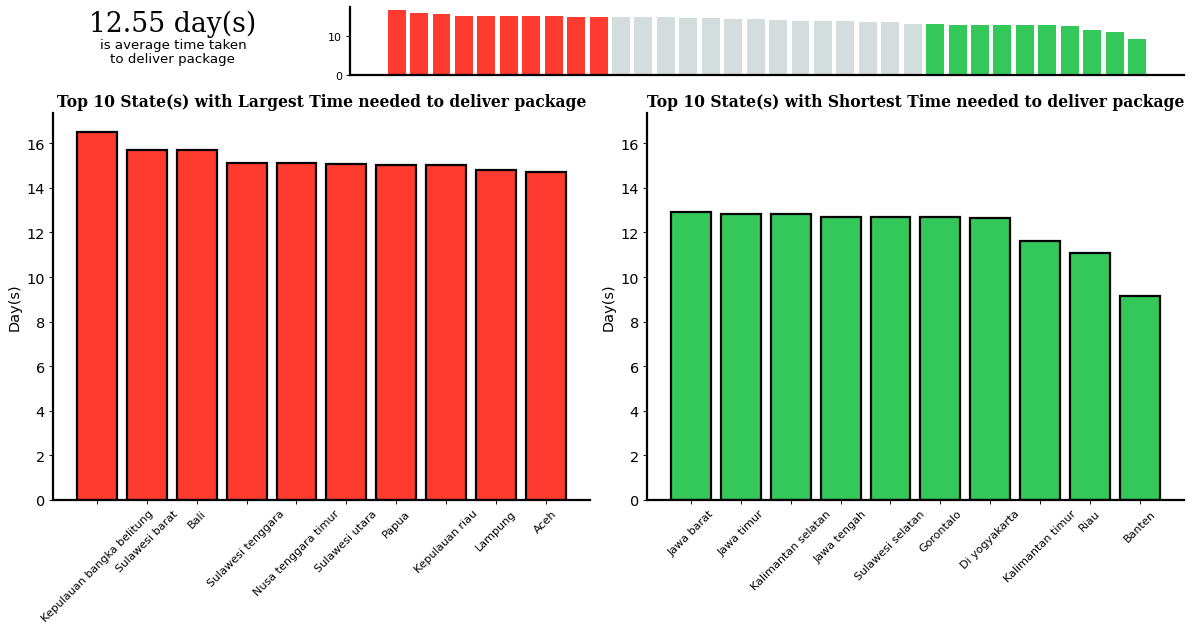

In [48]:
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(5, 8)

ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1:,:4])
ax4 = fig.add_subplot(gs[1:,4:])

# === Plot 1 : Annotate average time taken to deliver package ===
ax1.text(0.50, 0.65, f'{round(order_df.wd_actual_delivery_interval.mean(), 2)} day(s)', fontsize=24, fontfamily="serif", ha='center')
ax1.text(0.50, 0.40, 'is average time taken', fontsize=12, ha='center')
ax1.text(0.50, 0.20, 'to deliver package', fontsize=12, ha='center')
ax1.axis('off')
# === Plot 2 : Average time taken to deliver package per state ===

# Prepare
values = order_df.groupby(['customer_state']).agg(value=('wd_actual_delivery_interval', 'mean')).sort_values(by=['value'],ascending=False).value

# === All plot ===
x = values.index
y = values.values
ax2.bar(x, y,
       color=[light_palette[3]]*10 + ['#d4dddd']*(len(x) - 20) + [light_palette[2]] * 10
       )
ax2.set_xticks([])
# Spine
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

# === Specific ===
renaming_state = lambda val : " ".join(val.split("_")[:]).capitalize()
x_specify = x[:10]
y_specify = y[:10]
ax3.bar(x_specify, y_specify, edgecolor='black', linewidth=2, color=[light_palette[3]]*10)
ax3.set_xticks(range(len(x_specify)))
ax3.set_xticklabels(x_specify.map(renaming_state), rotation = 45)

# Spine
ax3.spines['bottom'].set_linewidth(2)
ax3.spines['left'].set_linewidth(2)
ax3.set_title("Top 10 State(s) with Largest Time needed to deliver package", fontsize=14, fontweight='bold', fontfamily='serif')
ax3.set_ylabel("Day(s)", fontsize=13, fontweight='medium')
ax3.tick_params(axis='y', which='major', labelsize=13)

# === Specific ===
x_specify = x[-10:]
y_specify = y[-10:]
ax4.bar(x_specify, y_specify, edgecolor='black', linewidth=2, color=[light_palette[2]] * 10)
ax4.set_xticks(range(len(x_specify)))

ax4.set_xticklabels(x_specify.map(renaming_state), rotation = 45)

# Spine
ax4.spines['bottom'].set_linewidth(2)
ax4.spines['left'].set_linewidth(2)
ax4.set_title("Top 10 State(s) with Shortest Time needed to deliver package", fontsize=14, fontweight='bold', fontfamily='serif')
ax4.set_ylabel("Day(s)", fontsize=13, fontweight='medium')
ax4.tick_params(axis='y', which='major', labelsize=13)
ax4.sharey(ax3)


plt.tight_layout()
plt.savefig("../reports/visualization/delivery-trend5.png")
plt.show()

***
<font size=-1><i>
<pre>How long are the delay for delivery / shipping process in each state?</pre>
We can see that 12.55 days are the average days needed to deliver the package from seller to customer.
<br>
From the states perspective, we can see that more developed states (like Banten, Riau and Kalimantan) have faster delivery time than other states like Kepulauan Bangka Belitung. 
</i>
</font>
***

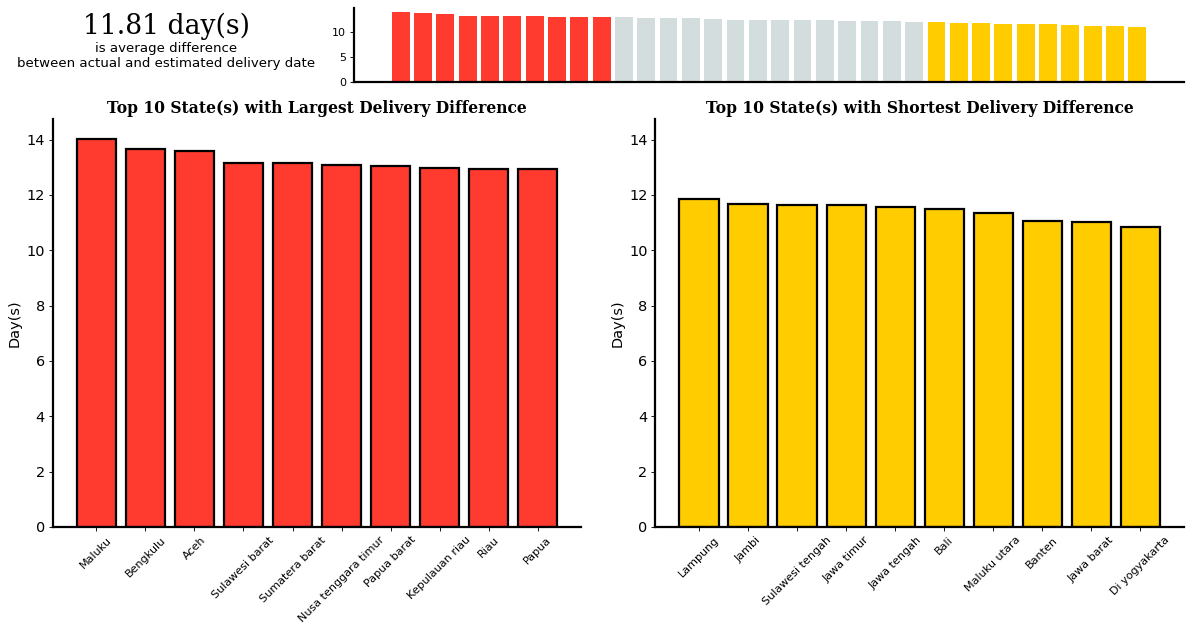

In [49]:
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(5, 8)

ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1:,:4])
ax4 = fig.add_subplot(gs[1:,4:])

# === Plot 1 : Annotate average time difference between estimated & actual delivery process ===
ax1.text(0.50, 0.65, f'{round(order_df.wd_actual_estimated_interval.mean(), 2) * -1} day(s)', fontsize=24, fontfamily="serif", ha='center')
ax1.text(0.50, 0.40, 'is average difference', fontsize=12, ha='center')
ax1.text(0.50, 0.20, 'between actual and estimated delivery date', fontsize=12, ha='center')
ax1.axis('off')
# === Plot 2 : Average time difference between estimated & actual delivery process per state ===

# Prepare
values = order_df.groupby(['customer_state']).agg(value=('wd_actual_estimated_interval', 'mean')).sort_values(by=['value'],ascending=True).value

# === All plot ===
x = values.index
y = values.values * -1
ax2.bar(x, y,
       color=[light_palette[3]]*10 + ['#d4dddd']*(len(x) - 20) + [light_palette[8]]*10
       )
ax2.set_xticks([])
# Spine
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

# === Specific ===
renaming_state = lambda val : " ".join(val.split("_")[:]).capitalize()
x_specify = x[:10]
y_specify = y[:10] 
ax3.bar(x_specify, y_specify, edgecolor='black', linewidth=2, color=[light_palette[3]] * 10)
ax3.set_xticks(range(len(x_specify)))
ax3.set_xticklabels(x_specify, rotation = 45)

# Spine
ax3.spines['bottom'].set_linewidth(2)
ax3.spines['left'].set_linewidth(2)
ax3.set_title("Top 10 State(s) with Largest Delivery Difference", fontsize=14, fontweight='bold', fontfamily='serif')
ax3.set_ylabel("Day(s)", fontsize=13, fontweight='medium')
ax3.tick_params(axis='y', which='major', labelsize=13)
ax3.set_xticklabels(x_specify.map(renaming_state), rotation = 45)

# === Specific ===
x_specify = x[-10:]
y_specify = y[-10:] 
ax4.bar(x_specify, y_specify, edgecolor='black', linewidth=2, color=[light_palette[8]] * 10)
ax4.set_xticks(range(len(x_specify)))

ax4.set_xticklabels(x_specify.map(renaming_state), rotation = 45)

# Spine
ax4.spines['bottom'].set_linewidth(2)
ax4.spines['left'].set_linewidth(2)
ax4.set_title("Top 10 State(s) with Shortest Delivery Difference", fontsize=14, fontweight='bold', fontfamily='serif')
ax4.set_ylabel("Day(s)", fontsize=13, fontweight='medium')
ax4.tick_params(axis='y', which='major', labelsize=13)
ax4.sharey(ax3)



plt.tight_layout()
plt.savefig("../reports/visualization/delivery-trend6.png")
plt.show()

***
<font size=-1><i>
<pre>How long are the difference between actual and estimated delivery date?</pre>
We can see that 11.8 (~12) days are the average difference between actual and estimated delivery date, which is really bad for up and coming ecommerce. 
<br>
From the states perspective, we can see thatagain  more developed states (like Banten, Riau and Kalimantan) have shorter difference than other states
</i>
</font>
***

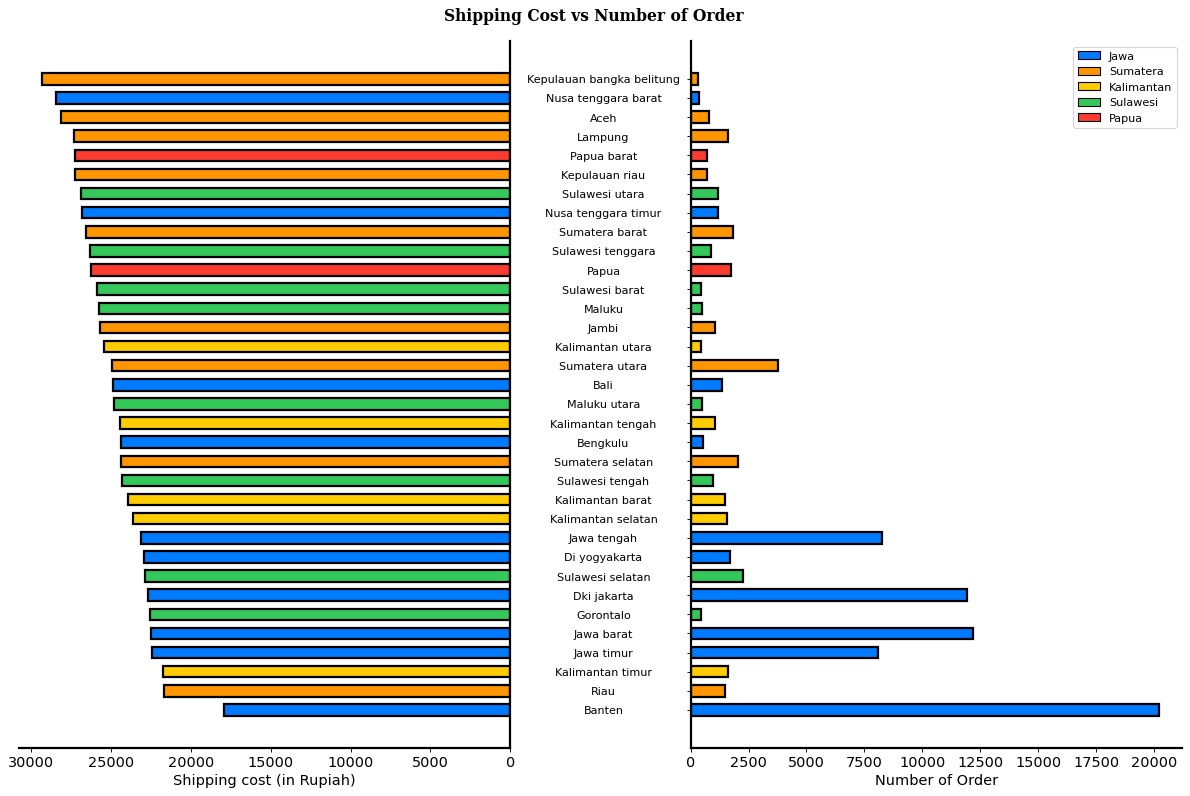

In [45]:
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

# === Define Index
values = order_df.groupby(['customer_state']).agg(value=('shipping_cost', 'mean')).sort_values(by=['value'],ascending=True).value
x =  values.index
# === y1 : Shipping cost ===
y1 = values.values
# == y2 :
order_per_state = order_df.customer_state.value_counts() 
y2 = np.array([
    order_per_state[state] for state in x 
])

state_color = [
     light_palette[1],  # Bangka Belitung
     light_palette[0],  # NTB
     light_palette[1],  # Aceh
     light_palette[1],  # Lampung
     light_palette[3],  # Papua Barat
     light_palette[1],  # Kep Riau
     light_palette[2],  # Sulawesi Utara
     light_palette[0],  # NTT
     light_palette[1],  # Sumatera Barat
     light_palette[2],  # Sulawesi Tenggara
     light_palette[3],  # Papua  
     light_palette[2],  # Sulawesi Barat
     light_palette[2],  # Maluku
     light_palette[1],  # Jambi
     light_palette[8],  # Kal ut
     light_palette[1],  # Sumut
     light_palette[0],  # Bali
     light_palette[2],  # Maluku
     light_palette[8],  # Kal tengah
     light_palette[0],  # Bengkulu 
     light_palette[1],  # Sum sel
     light_palette[2],  # Sul Tengah
     light_palette[8],  # Kal Bar
     light_palette[8],  # Kal Sel
     light_palette[0],  # Jawa Tengah
     light_palette[0],  # DI Yogya
     light_palette[2],  # Sulawesi Selatan
     light_palette[0],  # DKI Jakarta 
     light_palette[2],  # Gorontalo
     light_palette[0],  # Jawa Barat
     light_palette[0],  # Jawa Timur 
     light_palette[8],  # Kalimantan Timur
     light_palette[1],  # Riau
     light_palette[0],  # Banten      
]
state_color.reverse()

# Plot 1 : Shipping cost 
ax1.barh(x, y1, edgecolor='black', height=0.6,color=state_color, linewidth=2)
ax1.set_yticks([])
# ax1.set_yticklabels(x.map(renaming_state))
ax1.invert_xaxis()
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)

# Spine
for s in ['top',  'left']:
    ax1.spines[s].set_visible(False)

ax1.spines["right"].set_visible(True)

ax1.set_xlabel("Shipping cost (in Rupiah)", fontsize=13, fontweight='medium')
ax1.tick_params(axis='x', which='major', labelsize=13)

# Plot 1 : Number of order 
ax2.barh(x, y2, edgecolor='black', height=0.6, color=state_color, linewidth=2)
ax2.set_yticks(range(len(x)))
ax2.set_yticklabels(x.map(renaming_state), ha = 'center')
ax2.spines['bottom'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)

# Spine
for s in ['top',  'right']:
    ax2.spines[s].set_visible(False)

ax2.spines["left"].set_visible(True)
plt.draw()
yax = ax2.get_yaxis()
# find the maximum width of the label on the major ticks
pads = [T.label.get_window_extent().width for T in yax.majorTicks]
pad = sum(pads)/len(pads)
yax.set_tick_params(pad=pad)

ax2.set_xlabel("Number of Order", fontsize=13, fontweight='medium')
ax2.tick_params(axis='x', which='major', labelsize=13)

legend_elements = [
  Patch(facecolor=light_palette[0], edgecolor="black", label='Jawa'), 
  Patch(facecolor=light_palette[1], edgecolor='black', label='Sumatera'),
  Patch(facecolor=light_palette[8], edgecolor='black', label='Kalimantan'),
  Patch(facecolor=light_palette[2], edgecolor='black', label='Sulawesi'),
  Patch(facecolor=light_palette[3], edgecolor='black', label='Papua'),
]
ax2.legend(handles=legend_elements,loc='upper right', ncol=1)

fig.suptitle(f'Shipping Cost vs Number of Order', fontsize=14, va= 'center', fontfamily='serif',fontweight='semibold')
plt.tight_layout()
plt.savefig("../reports/visualization/delivery-trend7.png")
plt.show()


***
<font size=-1><i>
It is very interesting to see that the more often the order occured for certain states, the shipping cost is also lower (except from some states like Kalimantan and Riau). This might indicate that it will be hard to get new customer from low frequent order states because the shipping cost are so pricey. 
</i>
</font>
***

<font color="slategray" size=+0.5><b>Insight</b></font>

<font size=-1>
<i>
As final takeaway, here are the things that we need to look out for : 
<ul>
  <font size=-1>
  <li>User most likely to give bad feedback for late order. AVOID IT!</li>
  <li>Some product are easily shippable, but still have many late shipping. Finding out why some small product are late in shipping might help sales on those product type</li>
  <li>The average difference between actual & estimated duration is ~ 11 days. While that difference might be a way to avoid late order, the difference is too big and some user might don't like it.</li>
  <li>For state that have more order, the shipping cost is also lower.</li>
  </font>
</ul>
</i></font>

<font color="slategray" size=+0.5><b>Recommendation</b></font>

<font size=-1><i>
Based on insight that we get from the payment analysis, we can recommend few things:
    
    
<ul>
  <font size=-1>
      <li>To combat with the big difference between actual & estimated date delivery, we can try to make a shipping / delivery duration estimate system with higher accuracy for user</li>    
     <li>The proposed system above can also be used to measure the shipping process performance (KPI) on our ecommerce</li>
  <font>
</ul>
</i></font>

---
# <font color="darkblue" size=+2.5><b><center>4. Reference</center></b></font>

Now, by the end of our detailed analysis based from customer perspective, I would want to share with you all the reference that I used for this analysis :
- [Importance of Returning User](https://www.orvador.com/blog/importance-of-ecommerce-returning-users/)
- [Growth on ecommerce](https://medium.com/swlh/the-growth-of-ecommerce-2220cf2851f3)
- [Basic of RFM Analysis](https://medium.com/@jackiekhuu.work/customer-segmentation-rfm-analysis-8007d62101cc#:~:text=RFM%20considers%20recency%2C%20frequency%20and,for%20segmentation%20driven%20database%20marketing)
- [Preparing Ecommerce Peak Season](https://www.giosg.com/blog/ecommerce-strategy-for-peak-season)
- [Ecommerce Startup Forecasting](https://medium.com/analytics-vidhya/e-commerce-startup-sales-forecasting-64a5d01bbad2)
- [Peak Season Guide](https://www.sendcloud.com/peak-season-2019-guide/)
- [Why Location Matter in Ecommerce](https://prospress.com/location-matter-ecommerce/)
- [Why Geolocation is Important for GeoTargeting](https://www.optimonk.com/why-geolocation-geotargeting-is-essential-for-ecommerce/)
- [Trend in Ecommerce Logistic](https://medium.com/@kepinsync/what-is-the-future-of-and-trends-in-e-commerce-logistics-b194a00bee6d)

# <h1 style="font-family:verdana;"> <center>🏆 Blicommerce Data Analysis Series 🐋</center> </h1>
<p><center style="color:#159364; font-family:cursive;"><cite>Always find opportunities & money even if the data is not real. The Series~</cite></center></p>

***